## 1. Import Library & Datasets
* import necessary libraries 
* preprocess and merge datasets

### Load Libraries & Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk
import warnings
from copy import deepcopy
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
warnings.filterwarnings("ignore")

In [3]:
users = pd.read_csv('data/users.csv')
reviews = pd.read_csv('data/reviews.csv')

In [4]:
reviews.head()

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,restaurantID
0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,"Unlike Next, which we'd eaten at the previous ...",5,0,0,0,N,pbEiXam9YJL3neCYHGwLUA
1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,Probably one of the best meals I've had ever. ...,5,0,0,0,N,pbEiXam9YJL3neCYHGwLUA
2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,Service was impeccable. Experience and present...,3,2,0,0,N,pbEiXam9YJL3neCYHGwLUA
3,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,"The problem with places like this, given the e...",3,8,0,3,N,pbEiXam9YJL3neCYHGwLUA
4,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,I have no idea how to write my review - dining...,5,1,2,0,N,pbEiXam9YJL3neCYHGwLUA


There are 4 classes of flagged reviews by Yelp recommendation system. 
* N - Reviews that are confirmed as not fake 
* Y - Reviews that are confirmed as fake (least frequent label)
* NR - Reviews that are not confirmed as fake but flagged for investigation (most frequent laabel)
* YR - Reviews that are suspected to be fake and require more review before confirmation 

In [5]:
reviews['flagged'].value_counts()

flagged
NR    402774
YR    318678
N      58716
Y       8303
Name: count, dtype: int64

### Merge dataset

In [6]:
## inner join 
merged = pd.merge(reviews, users, on='reviewerID')

In [7]:
# drop rows with NR and YR in flagged column since NR and YR are not confirmed reviews
merged_filtered = merged[~merged['flagged'].isin(['YR', 'NR'])]

In [8]:
merged_filtered['flagged'].value_counts()

flagged
N    20752
Y     6206
Name: count, dtype: int64

### Check for Duplicates

In [9]:
# check for duplicated reviewID
duplicate_count = merged['reviewID'].duplicated().sum()
print(duplicate_count)

0


### Rename columns

In [10]:
merged_filtered.rename(columns={'usefulCount_x': 'usefulCount_review', 
                   'coolCount_x': 'coolCount_review',
                   'funnyCount_x': 'funnyCount_review',
                   'usefulCount_y': 'usefulCount_user',
                   'coolCount_y': 'coolCount_user',
                   'funnyCount_y': 'funnyCount_user'}, inplace=True)

In [11]:
merged_filtered.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'rating',
       'usefulCount_review', 'coolCount_review', 'funnyCount_review',
       'flagged', 'restaurantID', 'name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount_user',
       'coolCount_user', 'funnyCount_user', 'complimentCount', 'tipCount',
       'fanCount'],
      dtype='object')

In [12]:
# drop identifier columns
merged_filtered.drop(columns=['reviewID', 'reviewerID', 'restaurantID', 'name'], inplace=True)

In [13]:
merged_filtered.columns 

Index(['date', 'reviewContent', 'rating', 'usefulCount_review',
       'coolCount_review', 'funnyCount_review', 'flagged', 'location',
       'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount',
       'usefulCount_user', 'coolCount_user', 'funnyCount_user',
       'complimentCount', 'tipCount', 'fanCount'],
      dtype='object')

In [14]:
data = deepcopy(merged_filtered)
df = deepcopy(merged_filtered)

## 2. Data Cleaning

### Data Information

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26958 entries, 0 to 430090
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                26958 non-null  object
 1   reviewContent       26956 non-null  object
 2   rating              26958 non-null  int64 
 3   usefulCount_review  26958 non-null  int64 
 4   coolCount_review    26958 non-null  int64 
 5   funnyCount_review   26958 non-null  int64 
 6   flagged             26958 non-null  object
 7   location            26949 non-null  object
 8   yelpJoinDate        26958 non-null  object
 9   friendCount         26958 non-null  int64 
 10  reviewCount         26958 non-null  int64 
 11  firstCount          26958 non-null  int64 
 12  usefulCount_user    26958 non-null  int64 
 13  coolCount_user      26958 non-null  int64 
 14  funnyCount_user     26958 non-null  int64 
 15  complimentCount     26958 non-null  int64 
 16  tipCount            26958 

In [16]:
df['flagged'].value_counts()  

flagged
N    20752
Y     6206
Name: count, dtype: int64

### Check for Missing Values

* there are 11 rows of missing values in reviewContent and location
* drop them because these fields are not quantitative field and difficult to impute 
* proportion of missing value is very little 11/26947

In [17]:
missing_values = df.isnull().sum()

missing_values = missing_values[missing_values > 0]
print("Columns with missing values:")
print(missing_values)

Columns with missing values:
reviewContent    2
location         9
dtype: int64


In [18]:
df = df.dropna(subset=['reviewContent', 'location'])

### Convert Date to Datetime Object
Columns : 
* date 
* yelpJoinDate

We found out there are 42 rows of NA values in the dataset (columns - dateYear and dateMonth) after we convert date to Datetime object. After inspecting the original data, we verified that it is due to invalid entry (string) in the date column. Since the number of NA values is very minimal, we proceed to drop these NA values from the dataset. 

In [19]:
df['yelpJoinDate'] = pd.to_datetime(df['yelpJoinDate'], errors='coerce')

In [20]:
# Extract year and month from yelpJoinDate
df['yelpJoinYear'] = df['yelpJoinDate'].dt.year
df['yelpJoinMonth'] = df['yelpJoinDate'].dt.month

In [21]:
df[['yelpJoinDate', 'yelpJoinYear', 'yelpJoinMonth']].head()

,yelpJoinDate,yelpJoinYear,yelpJoinMonth
0,2009-10-01,2009,10
1,2011-06-01,2011,6
2,2008-09-01,2008,9
3,2007-10-01,2007,10
4,2007-07-01,2007,7


In [22]:
# do the same to the date column

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['dateYear'] = df['date'].dt.year.astype('Int64')
df['dateMonth'] = df['date'].dt.month.astype('Int64')

df[['date', 'dateYear', 'dateMonth']].head()

,date,dateYear,dateMonth
0,2012-09-22,2012,9
1,2012-09-22,2012,9
2,2012-09-19,2012,9
3,2012-09-06,2012,9
4,2012-09-09,2012,9


In [23]:
# drop the date and yelpJoinDate columns
df.drop(columns=['date', 'yelpJoinDate'], inplace=True)

In [24]:
num_rows_with_missing = df.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {num_rows_with_missing}")

Number of rows with missing values: 42


In [25]:
# drop rows with missing values
df = df.dropna()

In [26]:
df.shape

(26905, 20)

## 3. Data Normality

* check whether numerical columns are normally distributed

Note : 'rating' is NOT a continous feature, it is a categorical feature --> conduct one hot encoding later

In [27]:
# List of continuous numerical columns
continuous_numerical_columns = [
    'usefulCount_review', 'coolCount_review', 'funnyCount_review',
    'friendCount', 'reviewCount', 'firstCount', 'usefulCount_user',
    'coolCount_user', 'funnyCount_user', 'complimentCount', 'tipCount',
    'fanCount'
]

### Histogram
* Visualize the numerical features to check for data normality (bell-shaped curve)
* Skewness - all numerical features are heavily skewed (right skewed = +ve skewed)

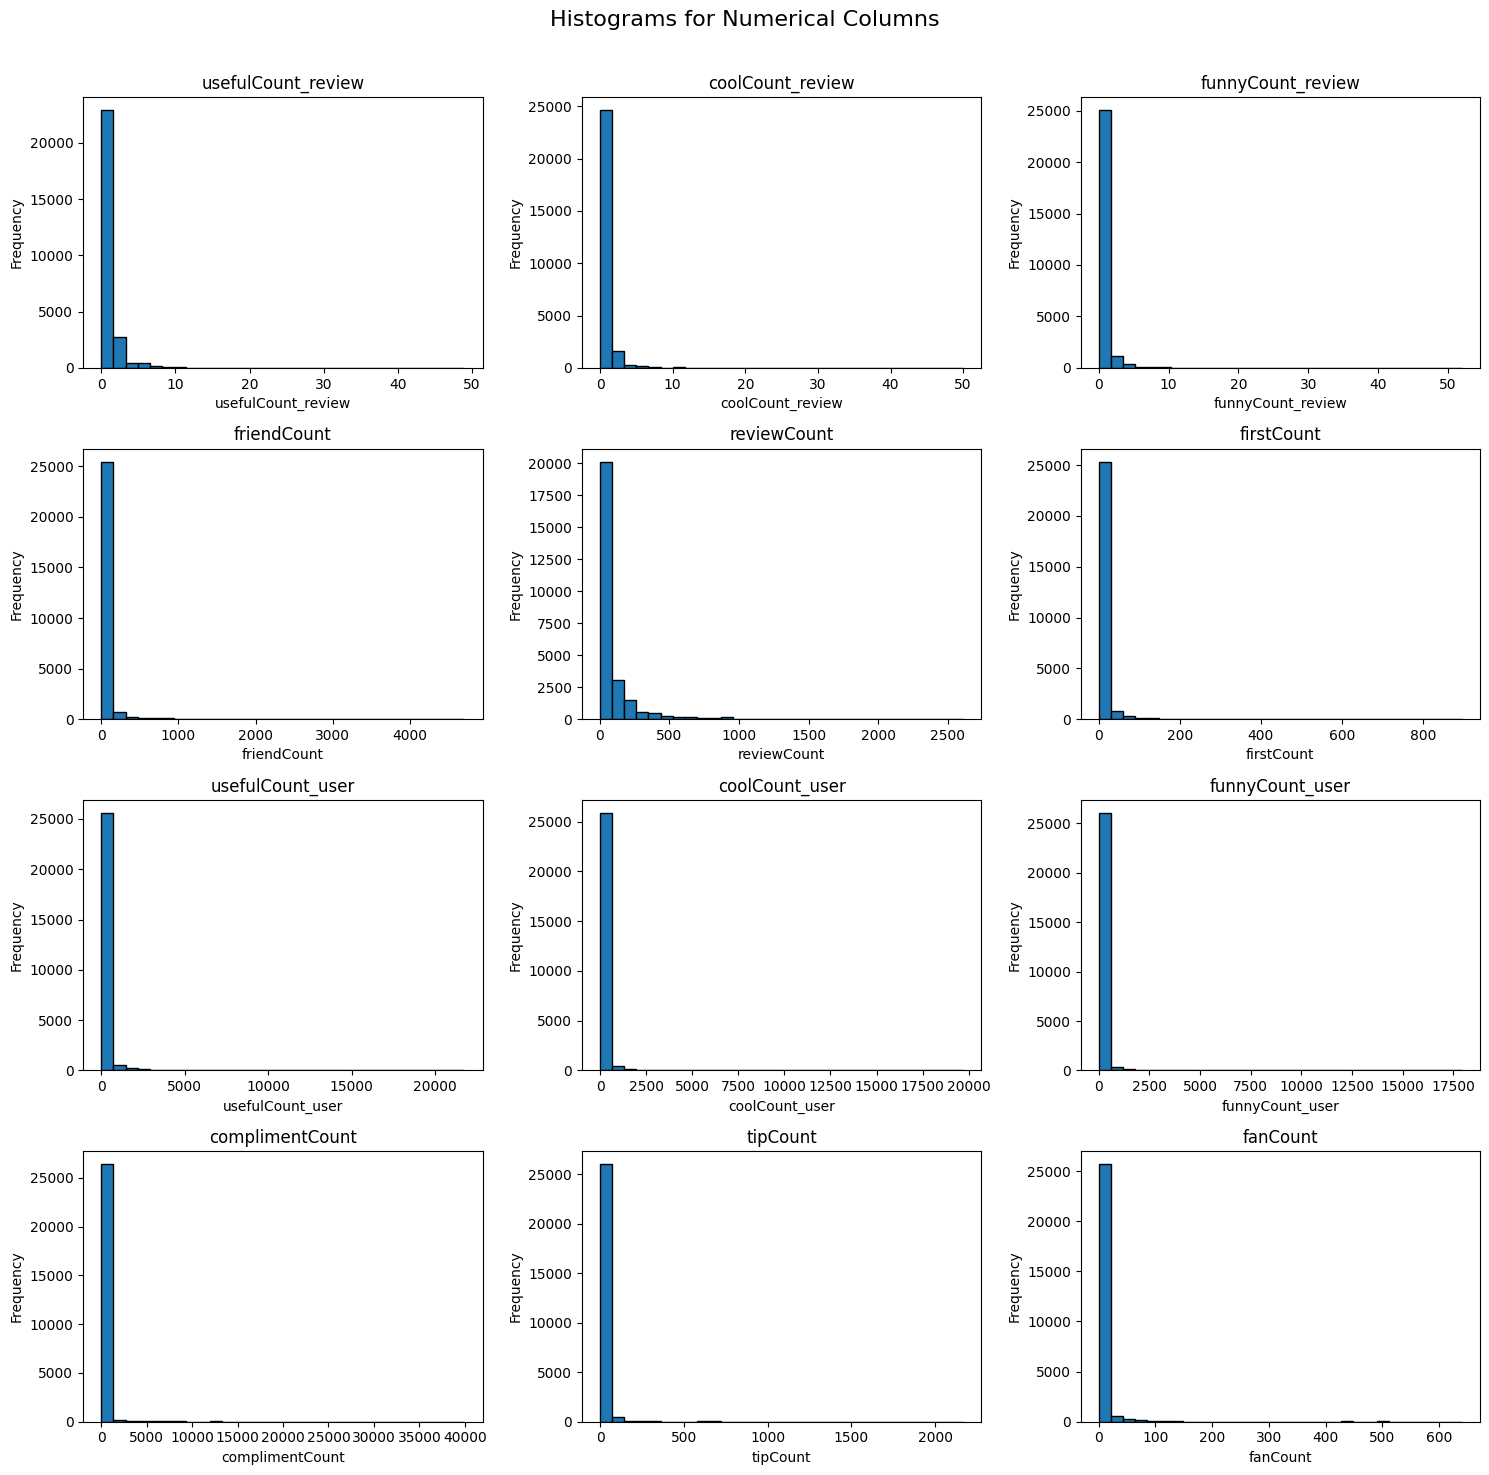

In [28]:
# historgam of numerical columns to visualize the distribution 

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Histograms for Numerical Columns', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate histograms for each numerical column
for i, column in enumerate(continuous_numerical_columns):
    axes[i].hist(df[column].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(continuous_numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
plt.show()

### Log Transformation 

Because the continous features are heavily skewed, therefore we apply log transformation before detecting outliers

In [29]:
# log transformation 
for column in continuous_numerical_columns:
    log_column_name = f"log_{column}"
    df[log_column_name] = np.log1p(df[column])

In [30]:
log_columns = [f"log_{column}" for column in continuous_numerical_columns]

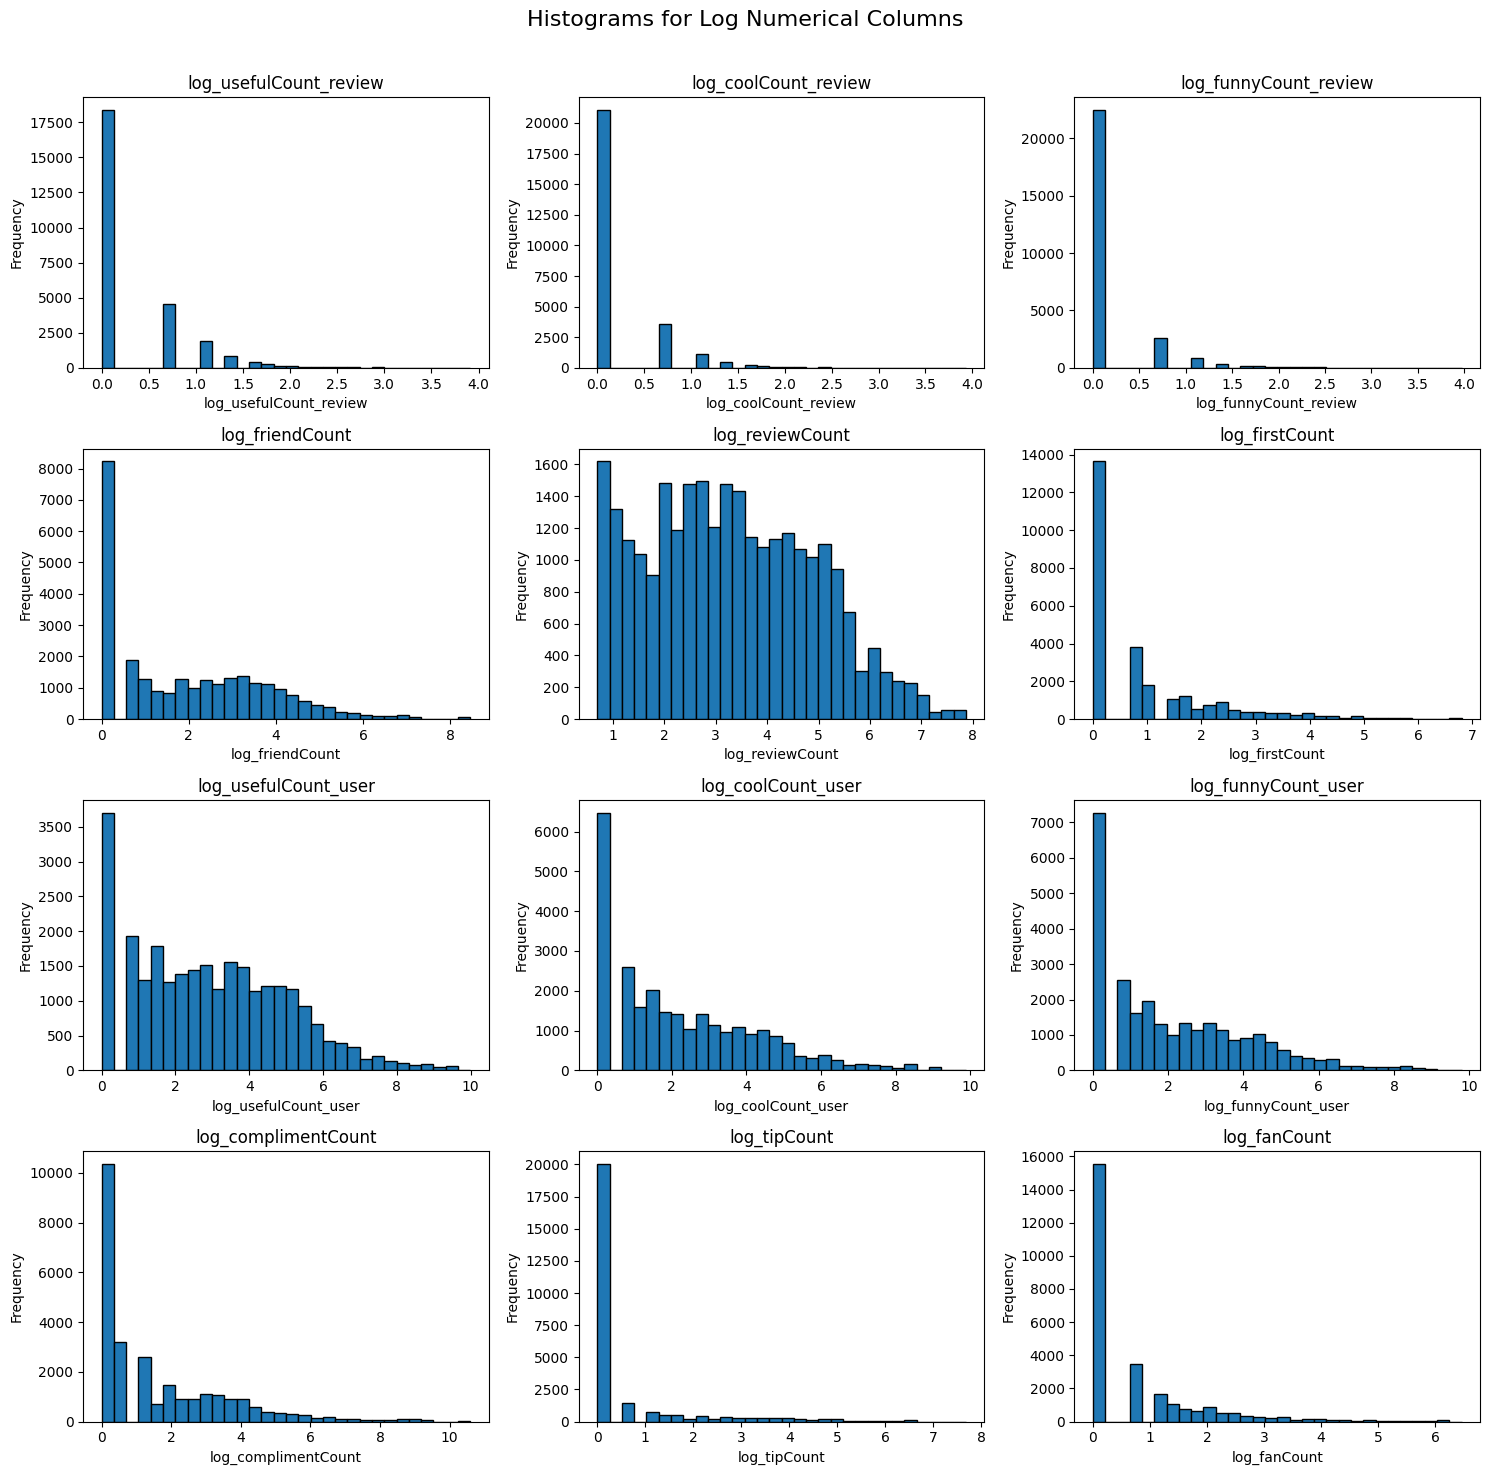

In [31]:
# historgam of log numerical columns to visualize the distribution after log transformation

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Histograms for Log Numerical Columns', fontsize=16)

axes = axes.flatten()

for i, column in enumerate(log_columns):
    axes[i].hist(df[column].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(log_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [32]:
df.drop(columns=continuous_numerical_columns, inplace=True)

## 4. Outlier Detection

### Detect Outlier
Detect outliers : 
* boxplot (visualize data to detect outlier)
* z-score : threshold=3: Z-score greater than 3 or less than -3 are considered outliers.
* Median Absolute Deviation (MAD) - data is not normally distributed


MAD the preferred way to detect outliers because : 

* The data is not normally distributed: MAD is more robust because it uses the median and median absolute deviation, which are less sensitive to extreme values or non-normal distributions.
* The data has heavy skewness or outliers: When your data is already skewed or contains a lot of natural outliers, MAD is preferred as it won’t be unduly influenced by those values.

For MAD, threshold +- 3.5 is suggested : https://stats.stackexchange.com/questions/123895/mad-formula-for-outlier-detection

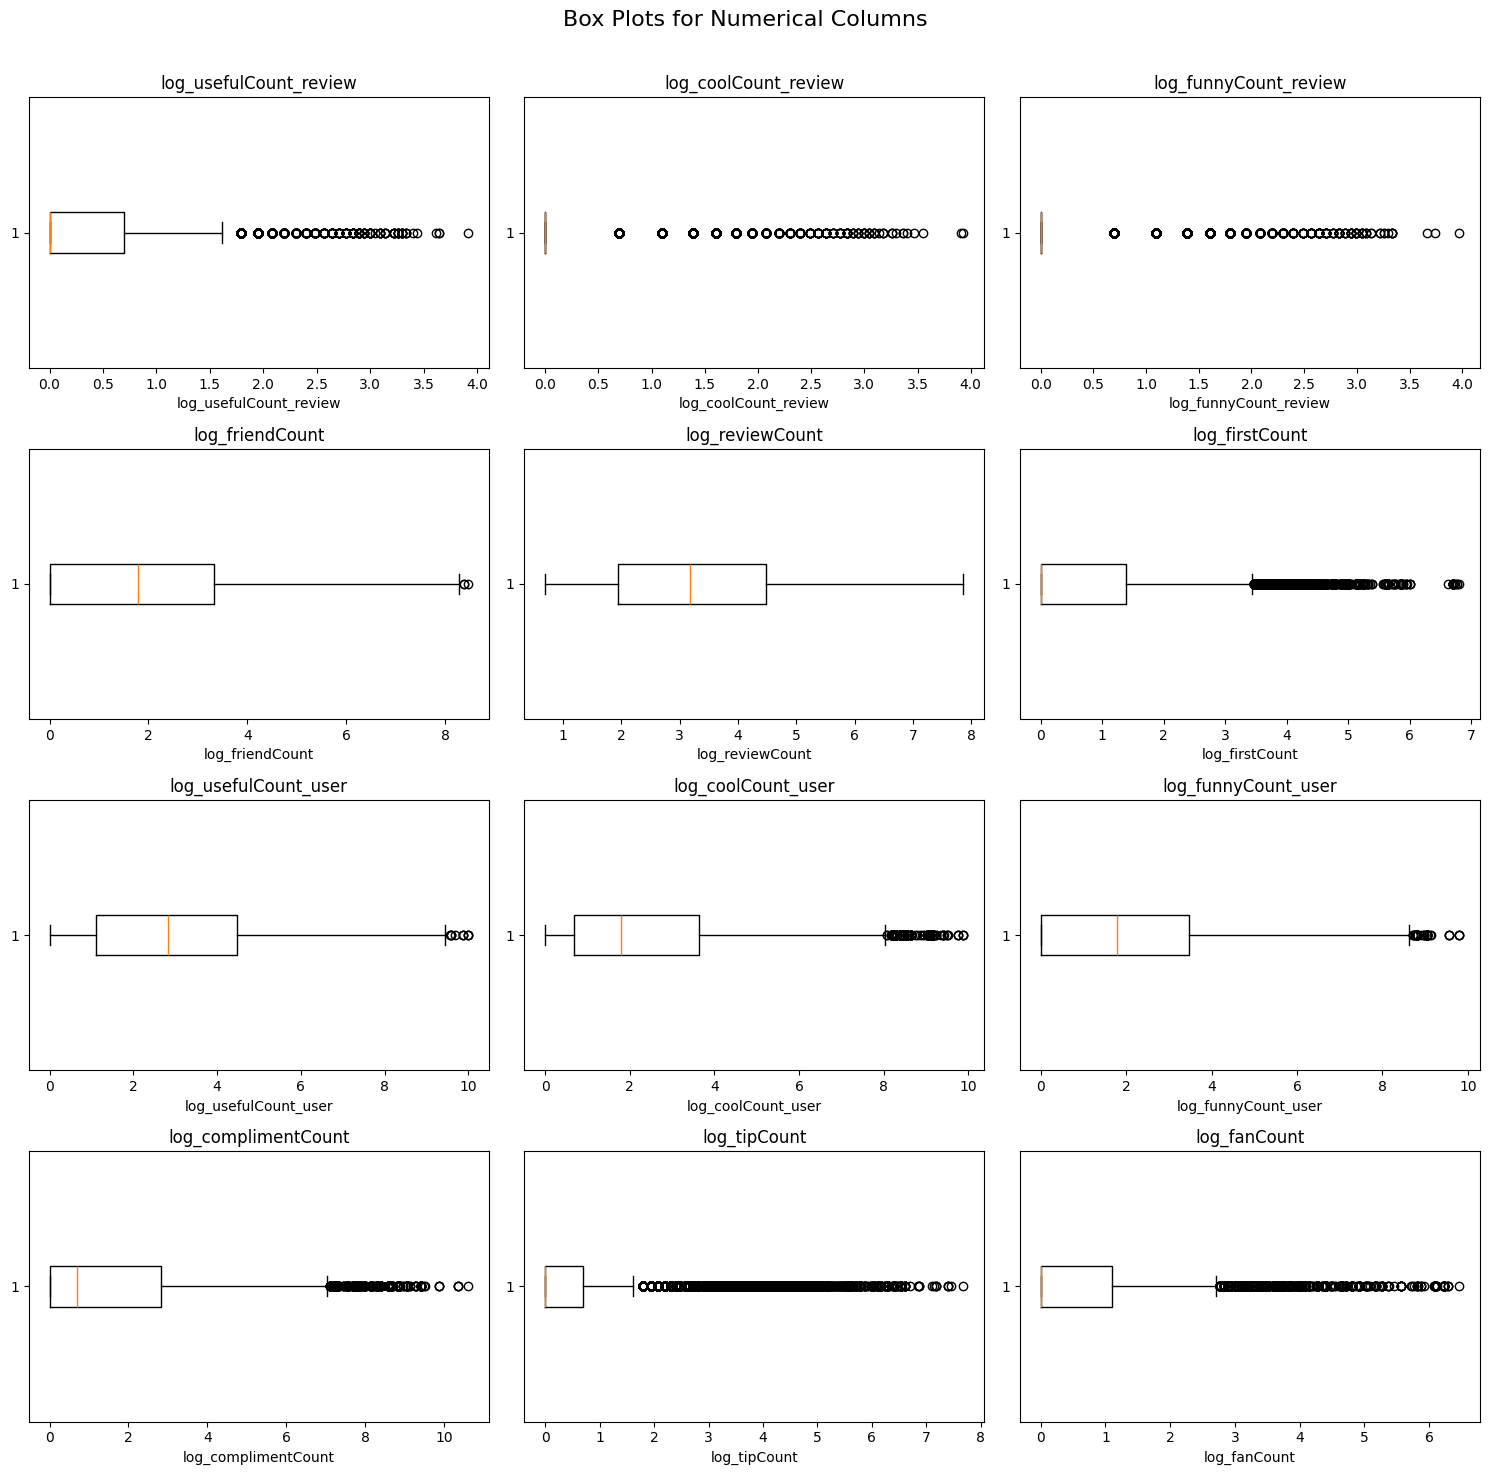

In [33]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Box Plots for Numerical Columns', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate box plots for each numerical column
for i, column in enumerate(log_columns):
    axes[i].boxplot(df[column].dropna(), vert=False)
    axes[i].set_title(column)
    axes[i].set_xlabel(column)

# Hide any unused subplots
for j in range(len(log_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
plt.show()

In [34]:
# Function to detect outliers using the Z-score method
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = zscore(data[column].dropna())
    outliers = data[(abs(z_scores) > threshold)]
    return len(outliers)

# Detect and print the number of outliers for each numerical column using the Z-score method
for column in log_columns:
    outlier_count = detect_outliers_zscore(df, column)
    print(f"Number of outliers in {column} using Z-score method: {outlier_count}")

# However, the Z-score method is sensitive to outliers itself and the log transformed data is not normally distributed.
# Therefore, we will use median and median absolute deviation (MAD) to detect outliers.

Number of outliers in log_usefulCount_review using Z-score method: 435
Number of outliers in log_coolCount_review using Z-score method: 705
Number of outliers in log_funnyCount_review using Z-score method: 669
Number of outliers in log_friendCount using Z-score method: 78
Number of outliers in log_reviewCount using Z-score method: 0
Number of outliers in log_firstCount using Z-score method: 428
Number of outliers in log_usefulCount_user using Z-score method: 65
Number of outliers in log_coolCount_user using Z-score method: 250
Number of outliers in log_funnyCount_user using Z-score method: 231
Number of outliers in log_complimentCount using Z-score method: 417
Number of outliers in log_tipCount using Z-score method: 773
Number of outliers in log_fanCount using Z-score method: 567


In [35]:
# Function to detect outliers using Modified Z-Score method (Median and MAD)
def detect_outliers_modified_zscore(data, column, threshold=3.5):
    median = np.median(data[column].dropna())
    mad = np.median(np.abs(data[column].dropna() - median))
    if mad == 0:  # To avoid division by zero
        return 0
    modified_z_scores = 0.6745 * (data[column] - median) / mad
    outliers = data[np.abs(modified_z_scores) > threshold]
    return len(outliers)

# Detect and print the number of outliers for each numerical column using the Modified Z-Score method
for column in log_columns:
    outlier_count = detect_outliers_modified_zscore(df, column)
    print(f"Number of outliers in {column} using Modified Z-Score method: {outlier_count}")

Number of outliers in log_usefulCount_review using Modified Z-Score method: 0
Number of outliers in log_coolCount_review using Modified Z-Score method: 0
Number of outliers in log_funnyCount_review using Modified Z-Score method: 0
Number of outliers in log_friendCount using Modified Z-Score method: 0
Number of outliers in log_reviewCount using Modified Z-Score method: 0
Number of outliers in log_firstCount using Modified Z-Score method: 0
Number of outliers in log_usefulCount_user using Modified Z-Score method: 0
Number of outliers in log_coolCount_user using Modified Z-Score method: 0
Number of outliers in log_funnyCount_user using Modified Z-Score method: 0
Number of outliers in log_complimentCount using Modified Z-Score method: 2660
Number of outliers in log_tipCount using Modified Z-Score method: 0
Number of outliers in log_fanCount using Modified Z-Score method: 0


In [36]:
# Function to detect outliers using Median and MAD
def get_outliers_mad(data, column, threshold=3.5):
    median = np.median(data[column].dropna())
    mad = np.median(np.abs(data[column].dropna() - median))
    if mad == 0:  # Avoid division by zero
        return data[[]]  # Return an empty DataFrame if no MAD can be calculated
    modified_z_scores = 0.6745 * (data[column] - median) / mad
    return data[np.abs(modified_z_scores) > threshold]

# Get the outliers for log_complimentCount
outliers_log_complimentCount = get_outliers_mad(df, 'log_complimentCount')

# Count 'Y' and 'N' in the flagged column
outliers_log_complimentCount['flagged'].value_counts()

flagged
N    2658
Y       2
Name: count, dtype: int64

### Handle Outliers 
We have 0.01% (271/26947) of extreme outliers of the log_complimentCount. Therefore, we use the capping (winsorize) method to handle the outliers. Cap the outliers to a defined max value which in our case is the 99th percentile to reduce their influence without removing them completely. 

Note : Not dropping outliers because they may contain useful information


In [37]:
# Calculate the 99th percentile value
percentile_99 = df['log_complimentCount'].quantile(0.99)

# Count the number of rows that are greater than or equal to the 99th percentile
rows_capped = df[df['log_complimentCount'] >= percentile_99].shape[0]

print(f"99th Percentile Value: {percentile_99}")
print(f"Number of Rows to be Capped: {rows_capped}")

99th Percentile Value: 8.289288323000317
Number of Rows to be Capped: 271


In [38]:
# Cap outliers at the 99th percentile
upper_limit_log_complimentCount = df['log_complimentCount'].quantile(0.99)
df['log_complimentCount'] = np.minimum(df['log_complimentCount'], upper_limit_log_complimentCount)

In [39]:
df.columns

Index(['reviewContent', 'rating', 'flagged', 'location', 'yelpJoinYear',
       'yelpJoinMonth', 'dateYear', 'dateMonth', 'log_usefulCount_review',
       'log_coolCount_review', 'log_funnyCount_review', 'log_friendCount',
       'log_reviewCount', 'log_firstCount', 'log_usefulCount_user',
       'log_coolCount_user', 'log_funnyCount_user', 'log_complimentCount',
       'log_tipCount', 'log_fanCount'],
      dtype='object')

## 5. EDA - Categorical

### Rating

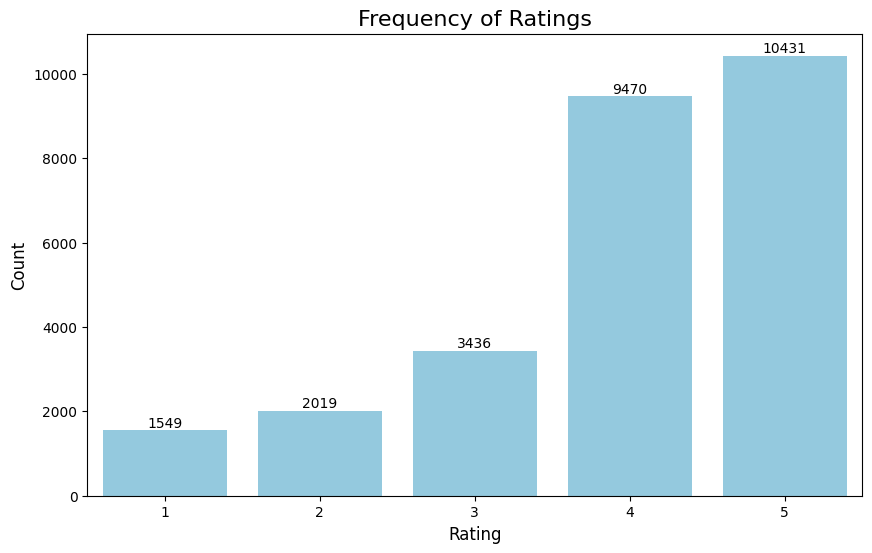

In [40]:
# Create a bar plot for ratings
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='rating', data=df, color='skyblue')  # Use color instead of palette

# Add bar labels with integer values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Convert height to integer
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize the plot
plt.title('Frequency of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### Rating By Year
* dateYear
* yelpJoinYear

Trend : decrease over years

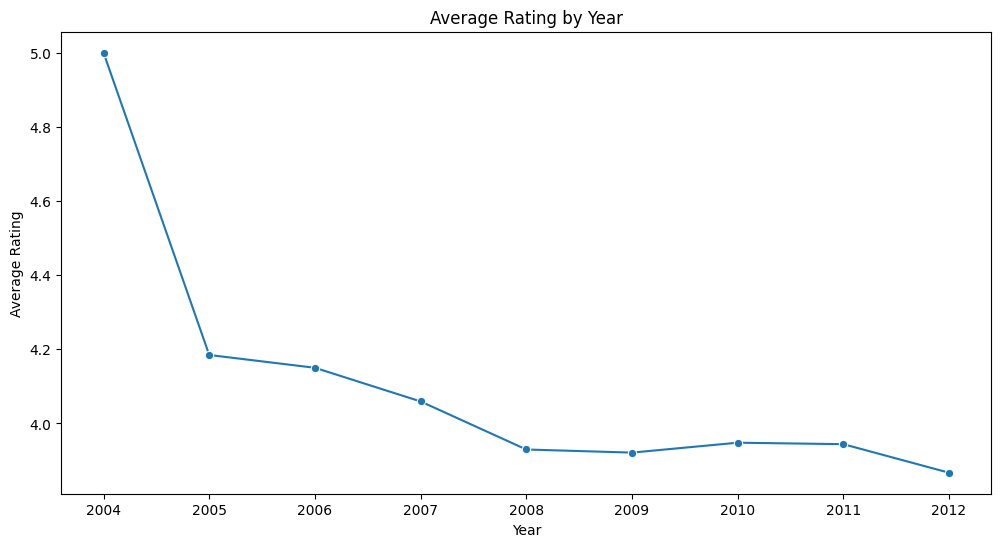

In [41]:
df_grouped = df.groupby('dateYear')['rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='dateYear', y='rating', data=df_grouped, marker='o')
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

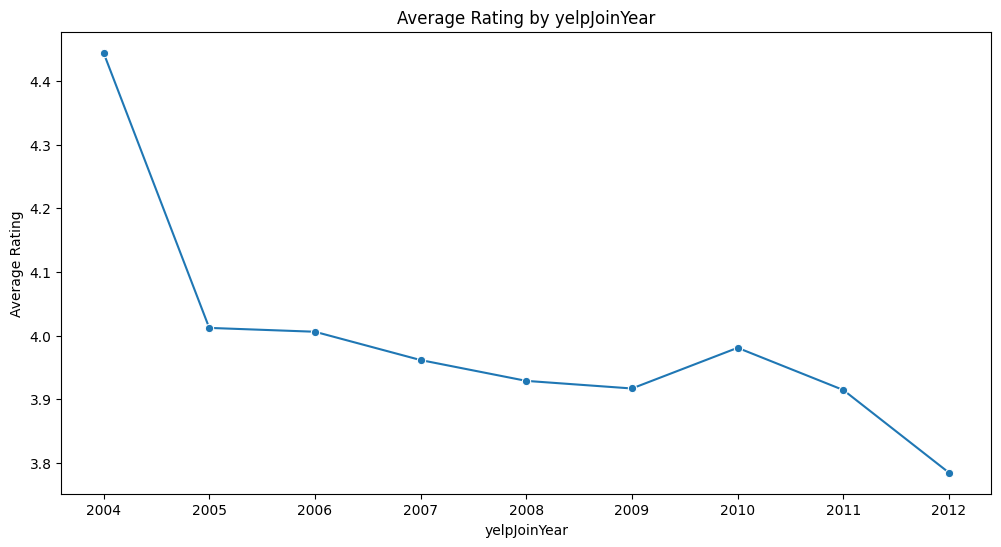

In [42]:
df_grouped = df.groupby('yelpJoinYear')['rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='yelpJoinYear', y='rating', data=df_grouped, marker='o')
plt.title('Average Rating by yelpJoinYear')
plt.xlabel('yelpJoinYear')
plt.ylabel('Average Rating')
plt.show()

### Frequency of Reviews by Date 
* dateYear 
* dateMonth

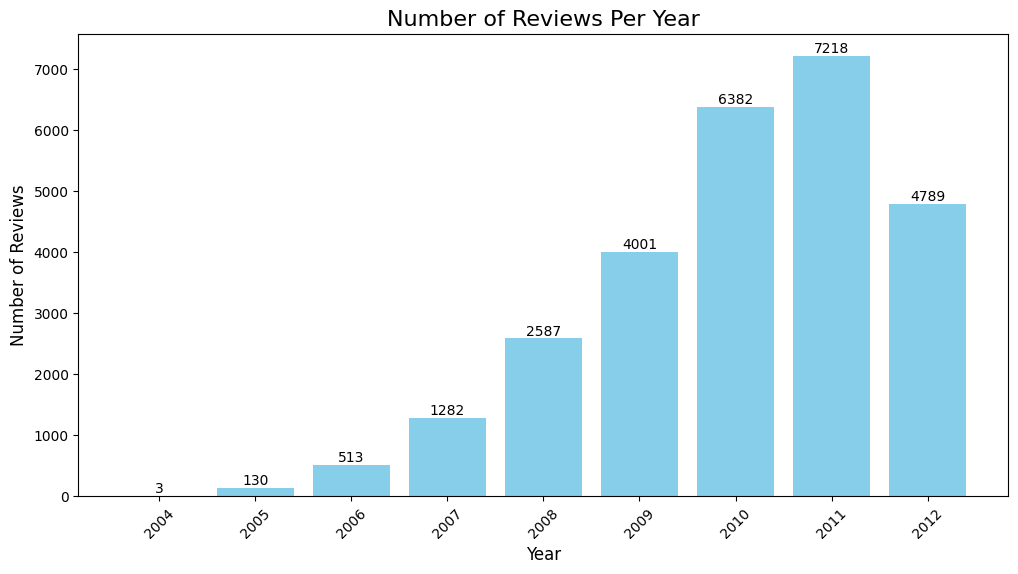

In [43]:
# Group
reviews_per_year = df.groupby('dateYear').size().reset_index(name='review_count')

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reviews_per_year['dateYear'], reviews_per_year['review_count'], color='skyblue')

for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display it
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position label
                 ha='center', va='bottom', fontsize=10, color='black')  # Align and format

plt.xticks(ticks=reviews_per_year['dateYear'], rotation=45)  # Ensure all years are displayed

plt.title('Number of Reviews Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

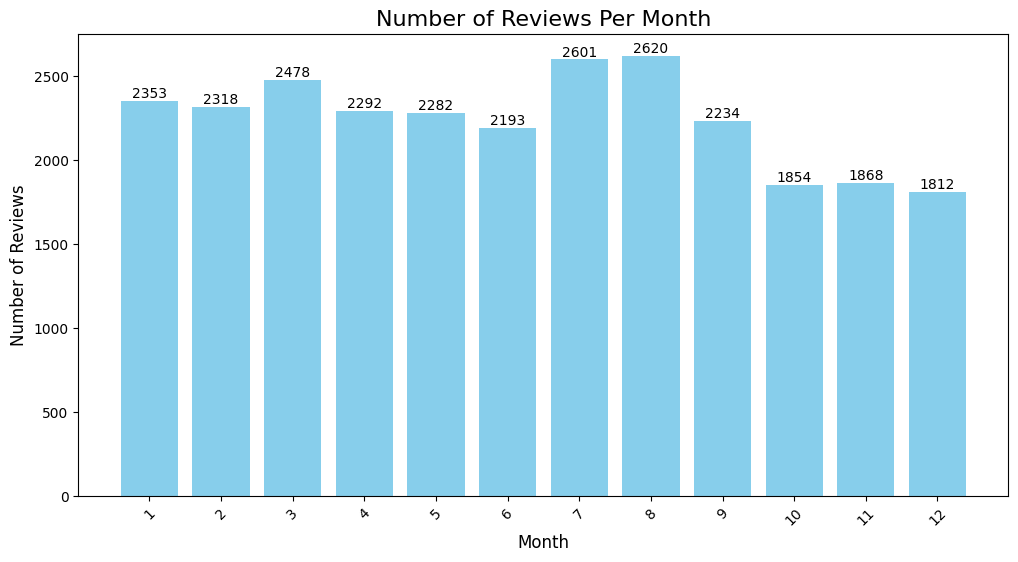

In [44]:
# Group
reviews_per_month = df.groupby('dateMonth').size().reset_index(name='review_count')

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reviews_per_month['dateMonth'], reviews_per_month['review_count'], color='skyblue')

for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display it
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position label
                 ha='center', va='bottom', fontsize=10, color='black')  # Align and format

plt.xticks(ticks=reviews_per_month['dateMonth'], rotation=45)  # Ensure all years are displayed

plt.title('Number of Reviews Per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

### Frequency of Reviews by yelpJoinDate 
* yelpJoinYear 
* yelpJoinMonth

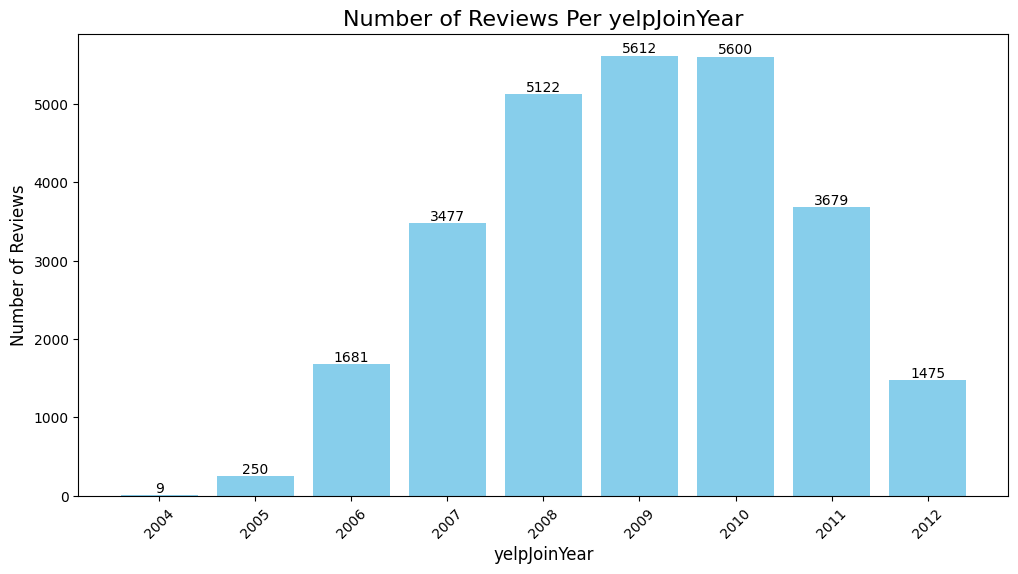

In [45]:
# Group
reviews_per_yelp_year = df.groupby('yelpJoinYear').size().reset_index(name='review_count')

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reviews_per_yelp_year['yelpJoinYear'], reviews_per_yelp_year['review_count'], color='skyblue')

for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display it
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position label
                 ha='center', va='bottom', fontsize=10, color='black')  # Align and format

plt.xticks(ticks=reviews_per_yelp_year['yelpJoinYear'], rotation=45)  # Ensure all years are displayed

plt.title('Number of Reviews Per yelpJoinYear', fontsize=16)
plt.xlabel('yelpJoinYear', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

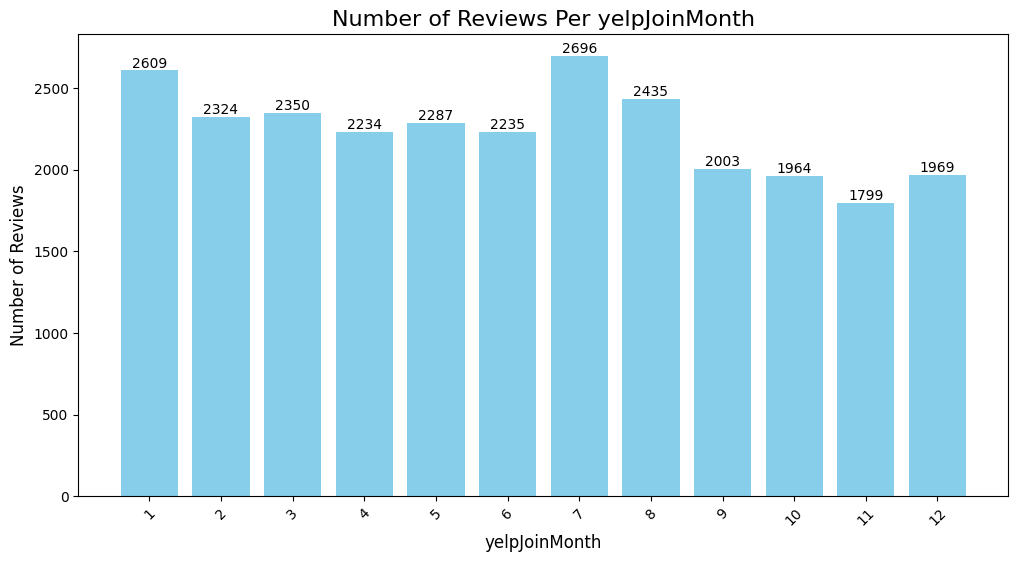

In [46]:
# Group
reviews_per_yelp_month = df.groupby('yelpJoinMonth').size().reset_index(name='review_count')

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reviews_per_yelp_month['yelpJoinMonth'], reviews_per_yelp_month['review_count'], color='skyblue')

for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display it
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position label
                 ha='center', va='bottom', fontsize=10, color='black')  # Align and format

plt.xticks(ticks=reviews_per_yelp_month['yelpJoinMonth'], rotation=45)  # Ensure all years are displayed

plt.title('Number of Reviews Per yelpJoinMonth', fontsize=16)
plt.xlabel('yelpJoinMonth', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

### Proportion of Categorical Features x Target (Flagged)
* proportion of ratings x target --> half half for rating 1 
* proportion of year x target 
* proportion of yelpJoinYear x target --> display increasing trend over the years

In [47]:
pivot_table_rating = df.pivot_table(
    index='rating',
    columns='flagged',
    aggfunc='size',
    fill_value=0
)

pivot_table_rating = pivot_table_rating.div(pivot_table_rating.sum(axis=1), axis=0)

pivot_table_rating

flagged,N,Y
rating,,
1,0.488702,0.511298
2,0.759782,0.240218
3,0.852445,0.147555
4,0.825026,0.174974
5,0.739431,0.260569


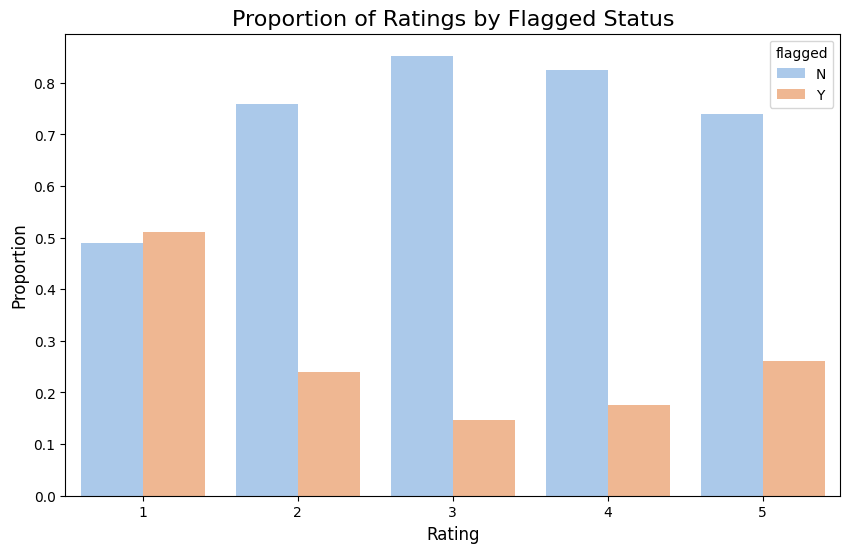

In [48]:
pivot_table_reset_rating = pivot_table_rating.reset_index().melt(id_vars='rating', value_name='proportion')

# Plot the proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table_reset_rating, x='rating', y='proportion', hue='flagged', palette='pastel')
plt.title('Proportion of Ratings by Flagged Status', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.show()

In [49]:
pivot_table_dateYear = df.pivot_table(
    index='dateYear',
    columns='flagged',
    aggfunc='size',
    fill_value=0
)

pivot_table_dateYear = pivot_table_dateYear.div(pivot_table_dateYear.sum(axis=1), axis=0)

# Display the pivot table
pivot_table_dateYear

flagged,N,Y
dateYear,,
2004,1.000000,0.000000
2005,0.861538,0.138462
2006,0.844055,0.155945
2007,0.826833,0.173167
2008,0.766138,0.233862
2009,0.741315,0.258685
2010,0.753369,0.246631
2011,0.784843,0.215157
2012,0.776154,0.223846


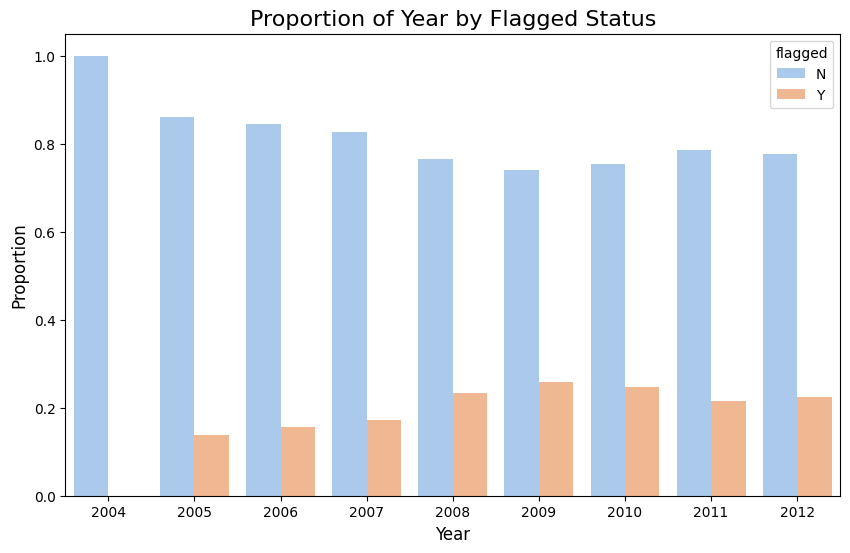

In [50]:
pivot_table_reset_dateYear = pivot_table_dateYear.reset_index().melt(id_vars='dateYear', value_name='proportion')

# Plot the proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table_reset_dateYear, x='dateYear', y='proportion', hue='flagged', palette='pastel')
plt.title('Proportion of Year by Flagged Status', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.show()

In [51]:
pivot_table_yelpYear = df.pivot_table(
    index='yelpJoinYear',
    columns='flagged',
    aggfunc='size',
    fill_value=0
)

pivot_table_yelpYear = pivot_table_yelpYear.div(pivot_table_yelpYear.sum(axis=1), axis=0)

pivot_table_yelpYear

flagged,N,Y
yelpJoinYear,,
2004,1.000000,0.000000
2005,0.924000,0.076000
2006,0.925640,0.074360
2007,0.899914,0.100086
2008,0.844592,0.155408
2009,0.778510,0.221490
2010,0.731250,0.268750
2011,0.638489,0.361511
2012,0.462373,0.537627


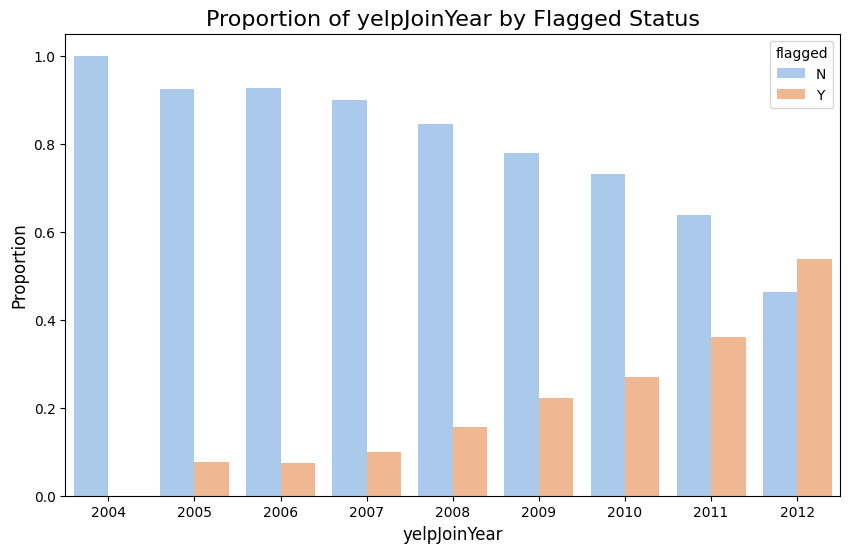

In [52]:
pivot_table_reset_yelpYear = pivot_table_yelpYear.reset_index().melt(id_vars='yelpJoinYear', value_name='proportion')

# Plot the proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table_reset_yelpYear, x='yelpJoinYear', y='proportion', hue='flagged', palette='pastel')
plt.title('Proportion of yelpJoinYear by Flagged Status', fontsize=16)
plt.xlabel('yelpJoinYear', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.show()

## 6. EDA - Numerical

### Correlation Heatmap
* Understand the linear relationship between numerical features
* Identify multicollinearity

Findings : 
* reviews features (top left) have high correlation between each other 
* users features (center) have high correlation between each other 
* multicollinearity : log_usefulCount_user, log_coolCount_user, log_funnyCount_user, log_complimentCount - are very highly correlated with each other (above 0.9).

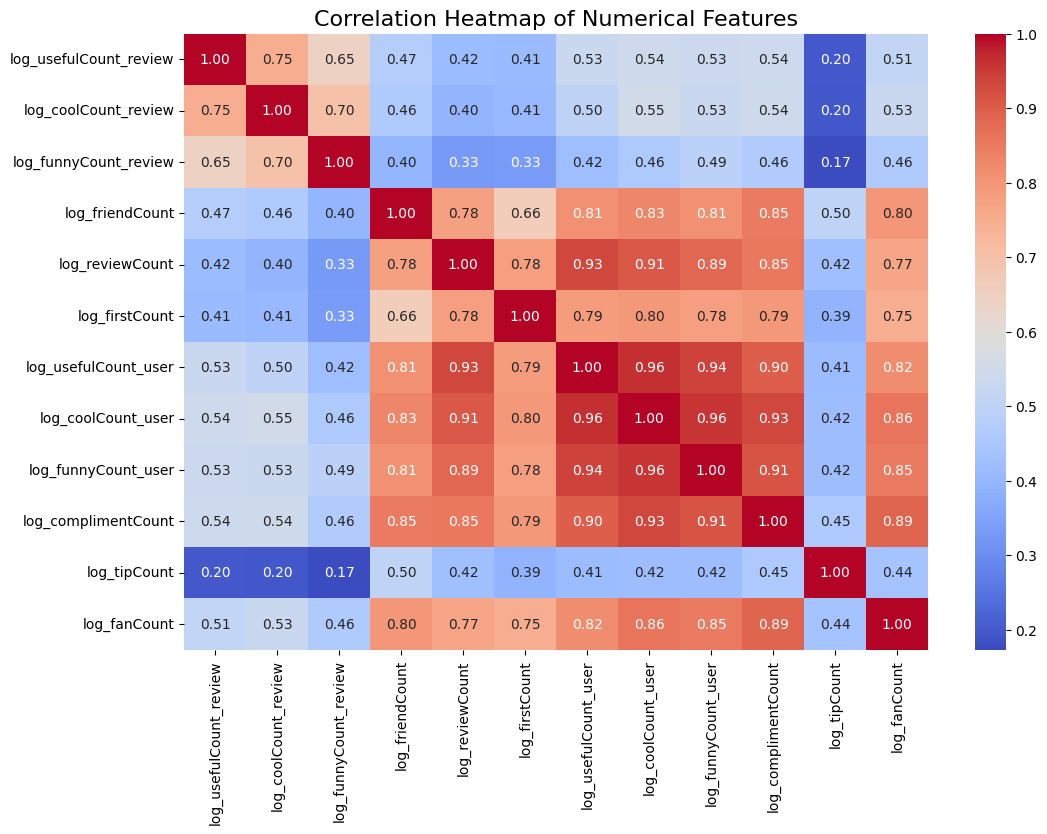

In [53]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[log_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

### Dealing with Multicollinearity

Measure multicollinearity quantitatively using the Variance Inflation Factor (VIF). A high VIF value indicates high multicollinearity.

* VIF > 10: High multicollinearity, consider addressing it.
* VIF between 5–10: Moderate multicollinearity, monitor closely.
* VIF < 5: Acceptable level.

In [54]:
# Calculate VIF
df_numerical = df[log_columns]
vif_data = pd.DataFrame()
vif_data['Feature'] = df_numerical.columns
vif_data['VIF'] = [variance_inflation_factor(df_numerical.values, i) for i in range(df_numerical.shape[1])]

# Display VIF
print(vif_data)

                   Feature        VIF
0   log_usefulCount_review   3.648852
1     log_coolCount_review   3.681979
2    log_funnyCount_review   2.608176
3          log_friendCount   9.143801
4          log_reviewCount  20.917867
5           log_firstCount   4.730574
6     log_usefulCount_user  60.542202
7       log_coolCount_user  55.323594
8      log_funnyCount_user  30.326451
9      log_complimentCount  19.421119
10            log_tipCount   1.669753
11            log_fanCount   7.595347


In [55]:
# remove those columns with VIF higher than 10
df.drop(columns=['log_reviewCount', 'log_usefulCount_user', 'log_coolCount_user', 'log_funnyCount_user', 'log_complimentCount'], inplace=True)

In [56]:
df.columns

Index(['reviewContent', 'rating', 'flagged', 'location', 'yelpJoinYear',
       'yelpJoinMonth', 'dateYear', 'dateMonth', 'log_usefulCount_review',
       'log_coolCount_review', 'log_funnyCount_review', 'log_friendCount',
       'log_firstCount', 'log_tipCount', 'log_fanCount'],
      dtype='object')

### Split the numerical columns 
* from reviews dataset (dateYear is used in trend)
* from users dataset (yelpJoinYear is used in trend)

In [57]:
log_numerical_reviews_columns = ['log_usefulCount_review', 
                                 'log_coolCount_review', 
                                 'log_funnyCount_review']

In [58]:
log_numerical_users_columns = ['log_friendCount', 
                               'log_firstCount', 
                               'log_tipCount', 
                               'log_fanCount']

### Trends of REVIEW numerical values over Year

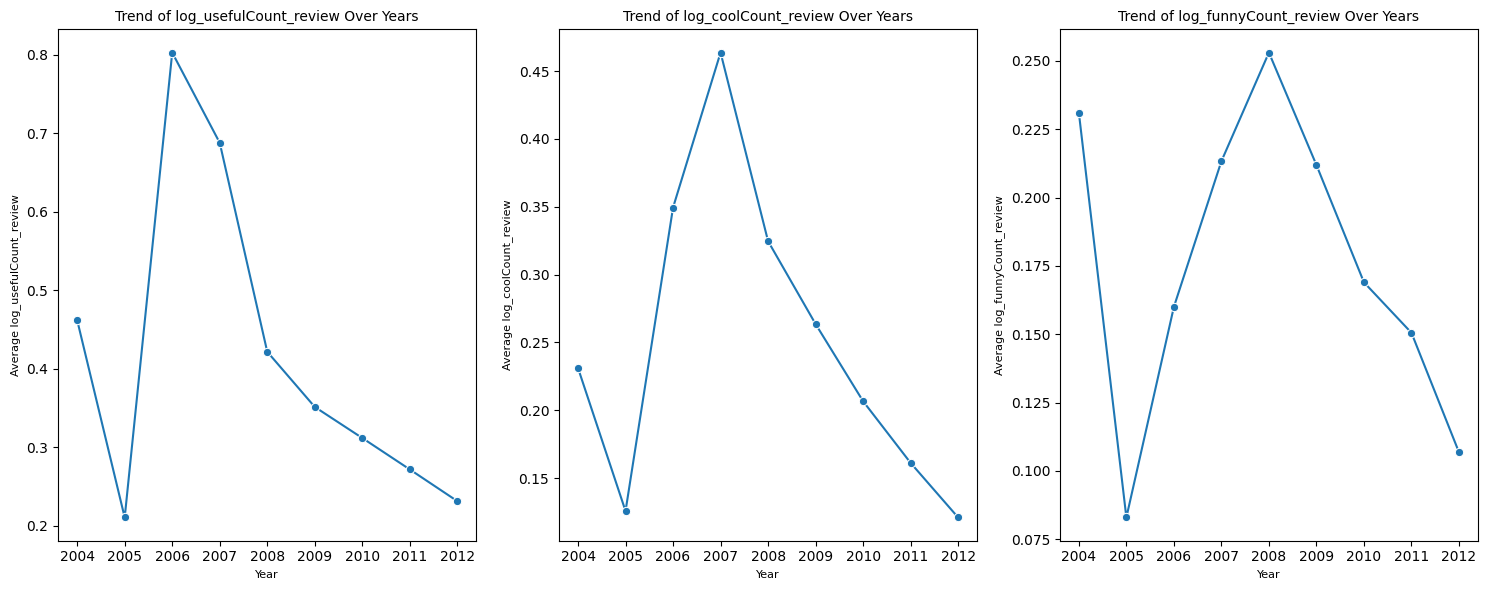

In [59]:
# Create a grid for multiple line plots
fig, axes = plt.subplots(1, 3, figsize=(15, 6)) 
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot trends for each log-transformed numerical column
for i, col in enumerate(log_numerical_reviews_columns):  # Replace numerical_columns with your log_columns list if needed
    trend_data = df.groupby('dateYear')[col].mean().reset_index()
    sns.lineplot(ax=axes[i], x='dateYear', y=col, data=trend_data, marker='o')
    axes[i].set_title(f'Trend of {col} Over Years', fontsize=10)
    axes[i].set_xlabel('Year', fontsize=8)
    axes[i].set_ylabel(f'Average {col}', fontsize=8)

# Hide unused subplots (if any)
for j in range(len(log_numerical_reviews_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Trends of USER numerical values over yelpJoinYear

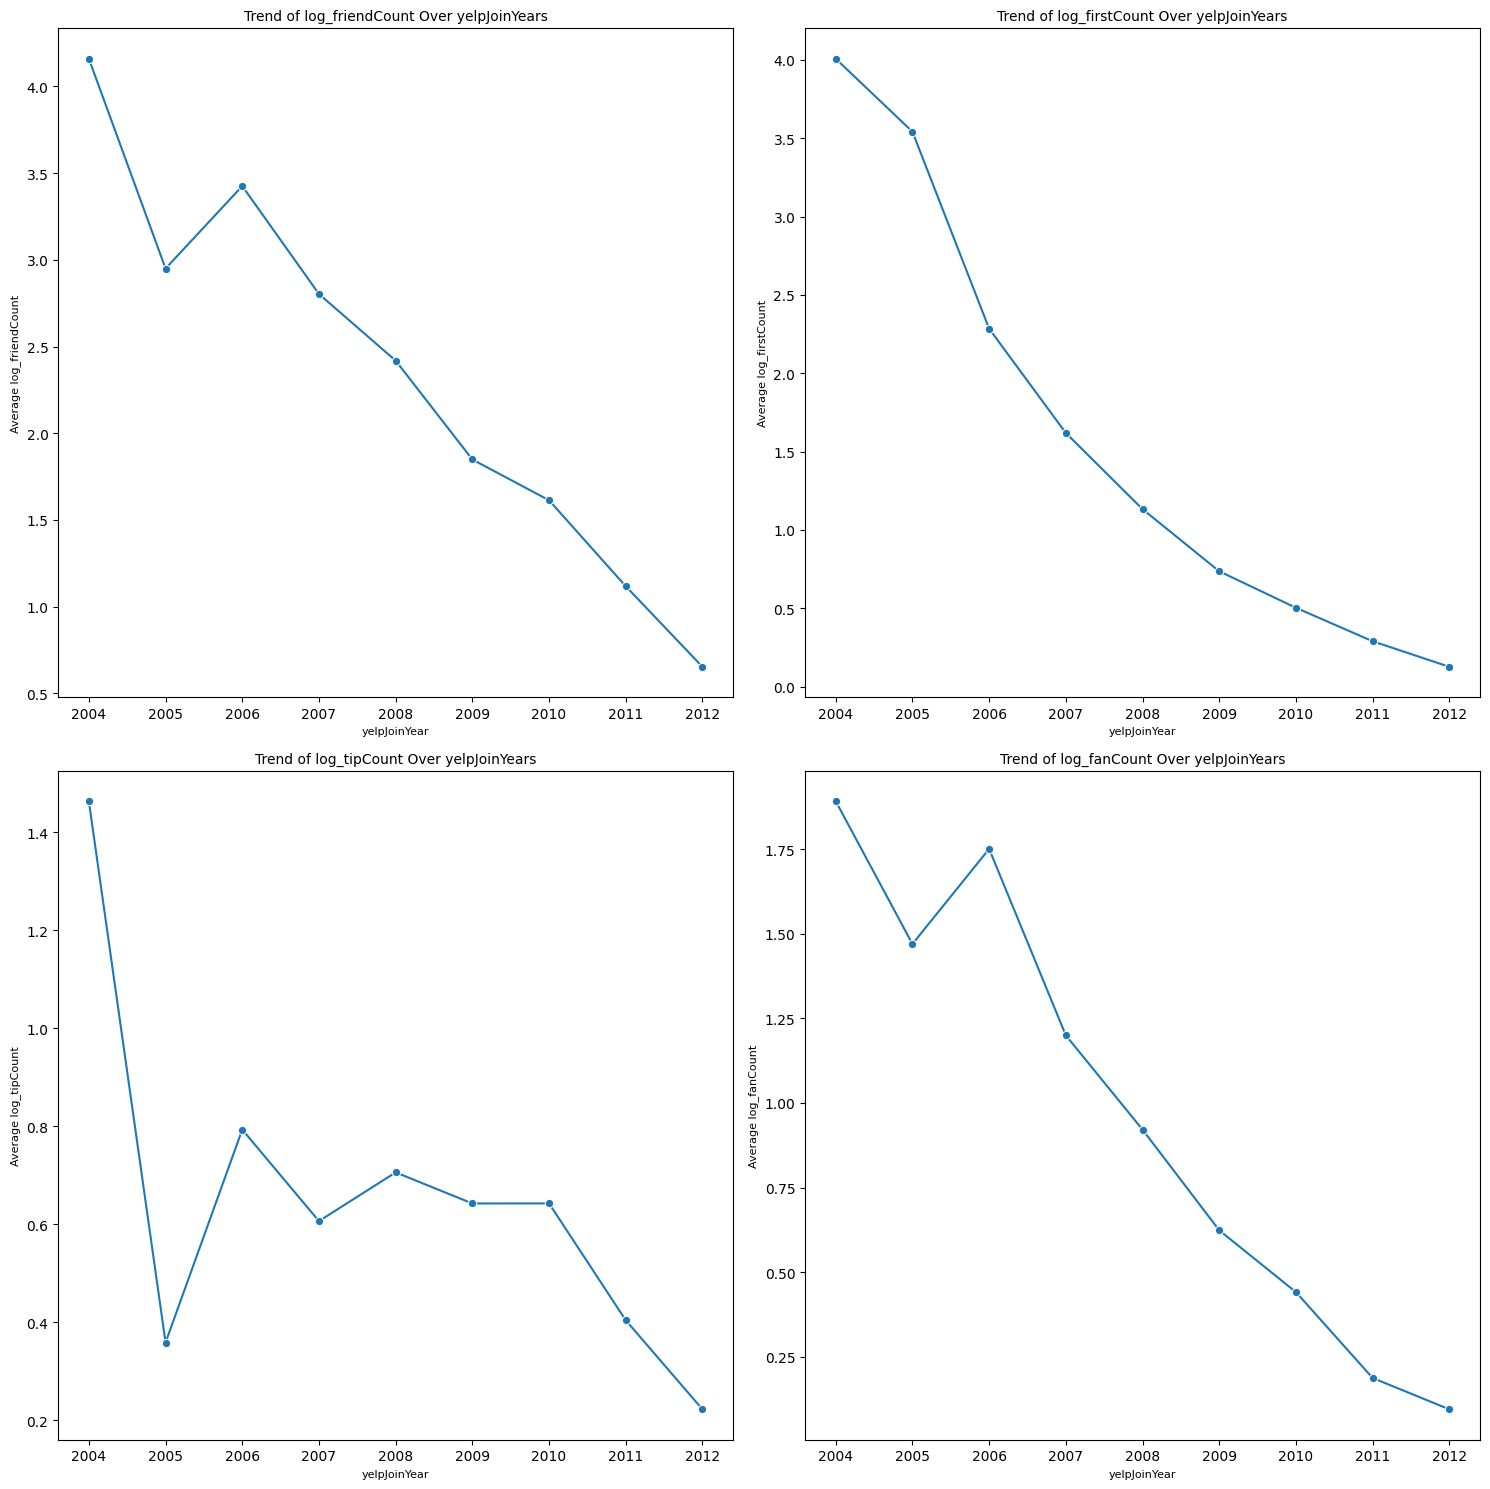

In [60]:
# Create a grid for multiple line plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot trends for each log-transformed numerical column
for i, col in enumerate(log_numerical_users_columns):  # Replace numerical_columns with your log_columns list if needed
    trend_data = df.groupby('yelpJoinYear')[col].mean().reset_index()
    sns.lineplot(ax=axes[i], x='yelpJoinYear', y=col, data=trend_data, marker='o')
    axes[i].set_title(f'Trend of {col} Over yelpJoinYears', fontsize=10)
    axes[i].set_xlabel('yelpJoinYear', fontsize=8)
    axes[i].set_ylabel(f'Average {col}', fontsize=8)

# Hide unused subplots (if any)
for j in range(len(log_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 7. Location
* Top 10 states
* Group those states with < 100 rows as 'Other'

In [61]:
df['state'] = df['location'].apply(lambda x: x.split(',')[-1].strip() if isinstance(x, str) else None)

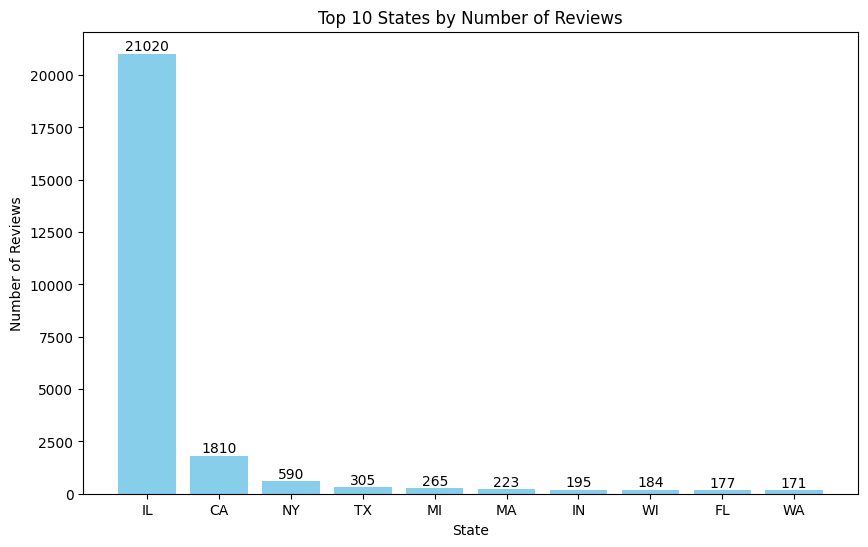

In [62]:
# Plot the top 10 states with bar labels
plt.figure(figsize=(10, 6))
state_counts = df['state'].value_counts().head(10)
bars = plt.bar(state_counts.index, state_counts.values, color='skyblue')

# Add bar labels
for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display as integer
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position above bar
                 ha='center', va='bottom', fontsize=10)

plt.title('Top 10 States by Number of Reviews')
plt.xlabel('State')
plt.ylabel('Number of Reviews')
plt.show()

In [63]:
# group those less than 100 as 'Other
state_counts = df['state'].value_counts()
df['state'] = df['state'].apply(lambda x: x if state_counts[x] >= 100 else 'Other')

print("Updated State Value Counts:\n", df['state'].value_counts())


Updated State Value Counts:
 state
IL       21020
CA        1810
Other      873
NY         590
TX         305
MI         265
MA         223
IN         195
WI         184
FL         177
WA         171
OH         167
PA         128
AZ         126
MN         122
MO         118
DC         112
CO         111
VA         105
GA         103
Name: count, dtype: int64


In [64]:
# drop the location column
df.drop(columns=['location'], inplace=True)

## 8. Text Analysis
Text feature - reviewContent
* Text Preprocessing & Cleaning
* Text analysis 
* Sentiment Analysis


### Text Preprocessing & Cleaning

* Remove HTML Tags: If the reviews have embedded HTML tags.
* Lowercase Conversion: Convert all text to lowercase to ensure uniformity.
* Remove Punctuation: Strip punctuation marks to focus on words.
* Remove Numbers: Exclude numerical data unless relevant to analysis.
* Remove Stopwords: Eliminate common words like “and,” “the,” etc., using a predefined stopword list.
* Tokenization: Split the text into individual words or tokens.
* Stemming or Lemmatization: Reduce words to their root form (e.g., “running” → “run”).

In [65]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lihuicham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lihuicham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lihuicham/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lihuicham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/lihuicham/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [66]:
# Initialize lemmatizer and stopword list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Lowercase conversion
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['reviewContent'] = df['reviewContent'].apply(preprocess_text)

### Text Analysis
* Word Count: Count the number of words in each review.
* Character Count: Count the total characters in each review.
* Sentiment Analysis: Use libraries like TextBlob or VADER to determine if a review is positive, negative, or neutral.
* N-Gram Analysis: Analyze frequent bigrams (pairs of words) or trigrams (triplets of words).

In [67]:
# Word count
df['word_count'] = df['reviewContent'].apply(lambda x: len(x.split()))

# Character count
df['char_count'] = df['reviewContent'].apply(len)


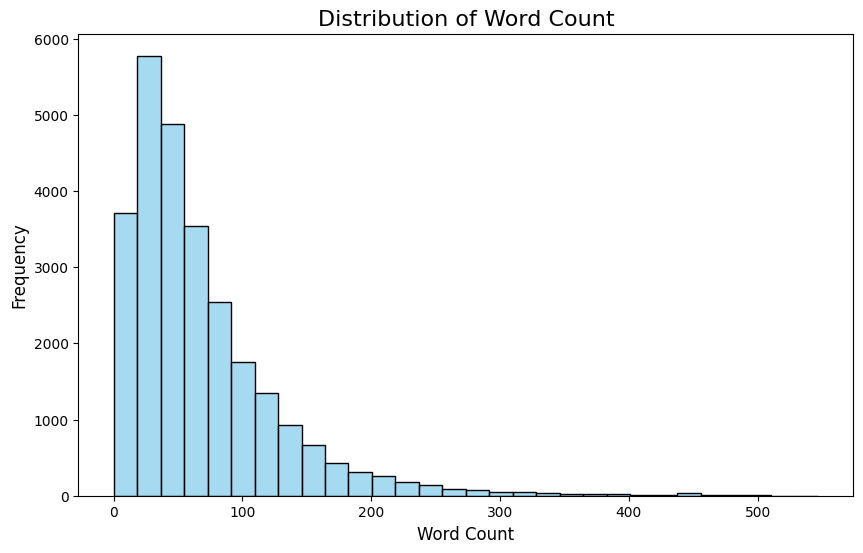

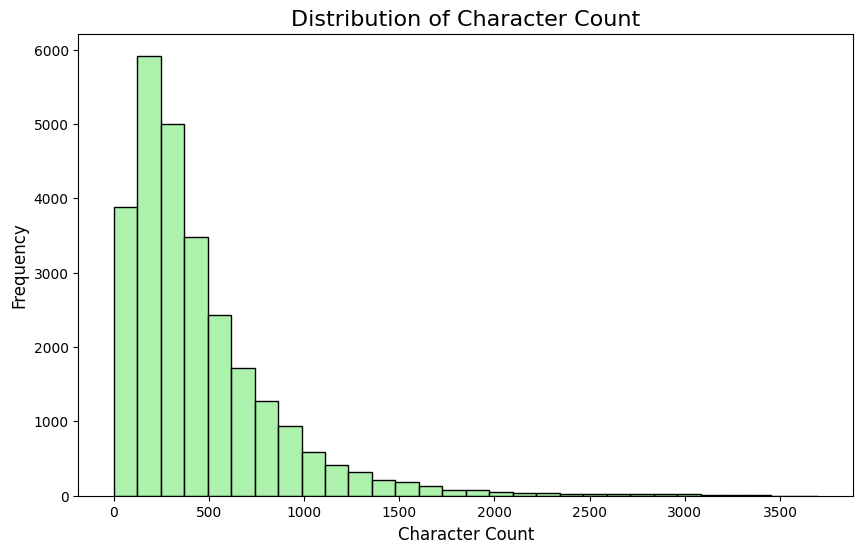

In [68]:
# Visualize the distribution of word count
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, color='skyblue')
plt.title('Distribution of Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Visualize the distribution of character count
plt.figure(figsize=(10, 6))
sns.histplot(df['char_count'], bins=30, color='lightgreen')
plt.title('Distribution of Character Count', fontsize=16)
plt.xlabel('Character Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

### Sentiment Analysis
Package used : TextBlob

* Polarity [-1.0 to 1.0] : -1.0 = extremely negative sentiment, 0.0 = neutral sentiment and 1.0 = extremely positive sentiment
* Subjectivity [0.0 to 1.0] : 0.0 = completely objective (fact-based), 1.0 = completely subjective (opinion-based)

Distribution of polarity and sentiment are bell shaped (normally distributed), similar pattern for N (real) and Y (fake) reviews


In [69]:
# Function to compute polarity and subjectivity
def analyze_sentiment(text):
    blob = TextBlob(text)
    return pd.Series({'polarity': blob.sentiment.polarity, 'subjectivity': blob.sentiment.subjectivity})

# Apply to the reviewContent column
df[['polarity', 'subjectivity']] = df['reviewContent'].apply(analyze_sentiment)

In [70]:
df[['reviewContent', 'polarity', 'subjectivity']].head()

,reviewContent,polarity,subjectivity
0,unlike next wed eaten previous night dish comp...,0.151420,0.526901
1,probably one best meal ive ever performance fo...,0.466667,0.566667
2,service impeccable experience presentation coo...,0.413333,0.720000
3,problem place like given exhorbitant cost medi...,0.120548,0.515464
4,idea write review dining alinea brings whole d...,0.132331,0.587594


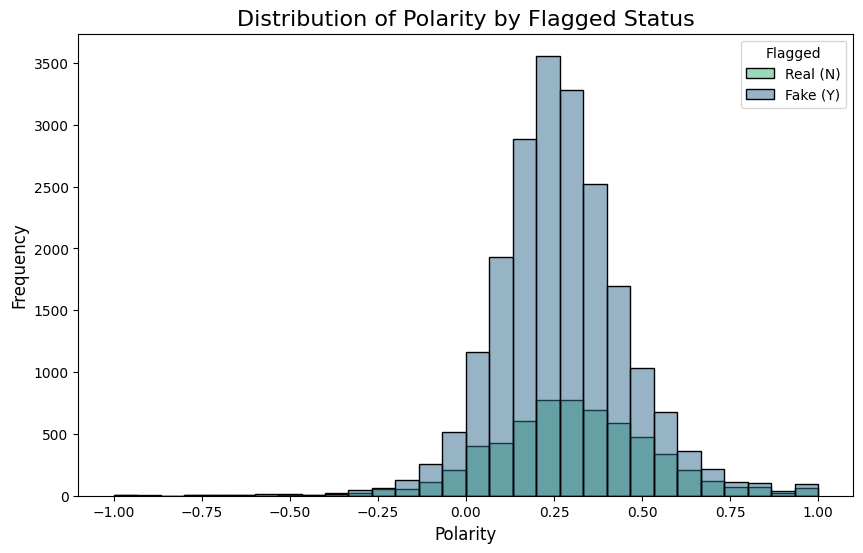

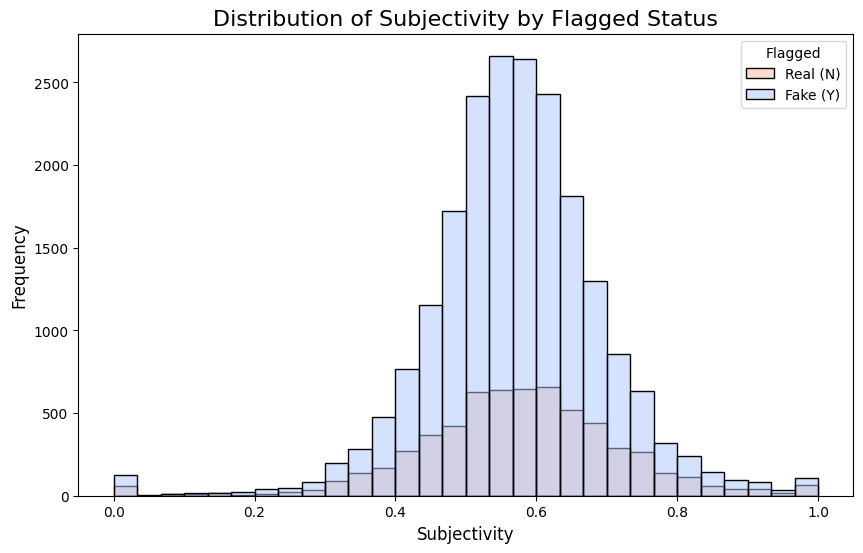

In [71]:
# Visualize polarity distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='polarity', bins=30, hue='flagged', palette='viridis', common_norm=False)
plt.title('Distribution of Polarity by Flagged Status', fontsize=16)
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

# Visualize subjectivity distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='subjectivity', bins=30, hue='flagged', palette='coolwarm', common_norm=False)
plt.title('Distribution of Subjectivity by Flagged Status', fontsize=16)
plt.xlabel('Subjectivity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

In [72]:
# Average polarity and subjectivity for flagged reviews
sentiment_by_flagged = df.groupby('flagged')[['polarity', 'subjectivity']].mean()
sentiment_by_flagged

,polarity,subjectivity
flagged,,
N,0.271210,0.570365
Y,0.297585,0.573460


        polarity  subjectivity
rating                        
1       0.014039      0.522440
2       0.121001      0.536003
3       0.210734      0.553695
4       0.298707      0.576231
5       0.349004      0.586126


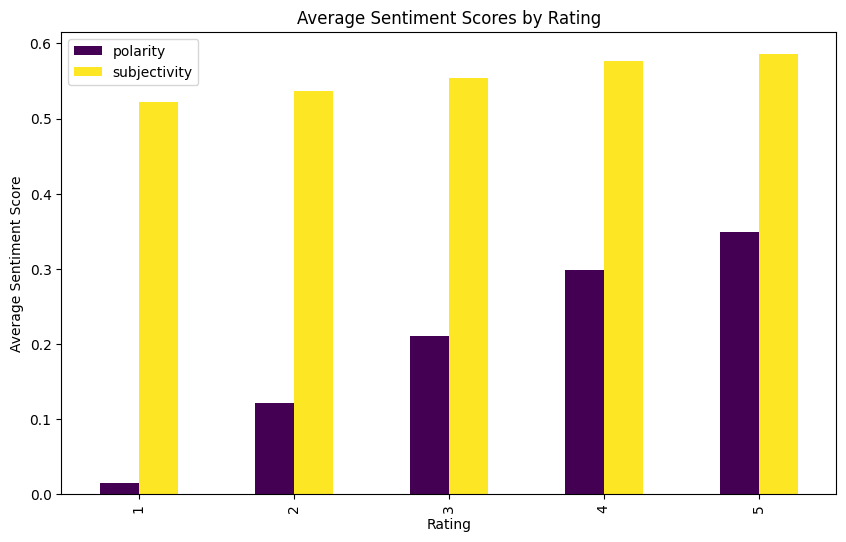

In [73]:
# Average polarity and subjectivity by rating
sentiment_by_rating = df.groupby('rating')[['polarity', 'subjectivity']].mean()
print(sentiment_by_rating)

# Visualize sentiment by rating
sentiment_by_rating.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Average Sentiment Scores by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.show()

### Part of Speech Tagging
* hue='flagged': Splits the data by the flagged column (N or Y) and overlays the distributions.
* common_norm=False: Ensures the distributions for “N” and “Y” are scaled independently, so the raw count imbalance doesn’t skew the visualization.

Distribution of noun count, verb count and adjective count are positively skewed (right skewed), similar pattern for N (real) and Y (fake) reviews

In [74]:
# Function to count POS tags
def pos_tagging(text):
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    pos_tags = nltk.pos_tag(tokens)  # POS tagging
    pos_counts = Counter(tag for word, tag in pos_tags)  # Count POS tags
    return pos_counts

# Apply POS tagging to the cleaned reviews
df['pos_counts'] = df['reviewContent'].apply(pos_tagging)

# Extract counts for specific POS tags (e.g., nouns, verbs, adjectives)
df['noun_count'] = df['pos_counts'].apply(lambda x: x.get('NN', 0) + x.get('NNS', 0))  # Singular & Plural Nouns
df['verb_count'] = df['pos_counts'].apply(lambda x: x.get('VB', 0) + x.get('VBD', 0) + x.get('VBG', 0) + x.get('VBN', 0) + x.get('VBP', 0) + x.get('VBZ', 0))  # Verbs
df['adj_count'] = df['pos_counts'].apply(lambda x: x.get('JJ', 0) + x.get('JJR', 0) + x.get('JJS', 0))  # Adjectives

# Display the updated DataFrame with POS counts
df[['reviewContent', 'noun_count', 'verb_count', 'adj_count']].head()

,reviewContent,noun_count,verb_count,adj_count
0,unlike next wed eaten previous night dish comp...,182,114,88
1,probably one best meal ive ever performance fo...,14,5,7
2,service impeccable experience presentation coo...,16,5,3
3,problem place like given exhorbitant cost medi...,96,26,56
4,idea write review dining alinea brings whole d...,42,9,22


In [75]:
df.drop(columns=['pos_counts'], inplace=True)

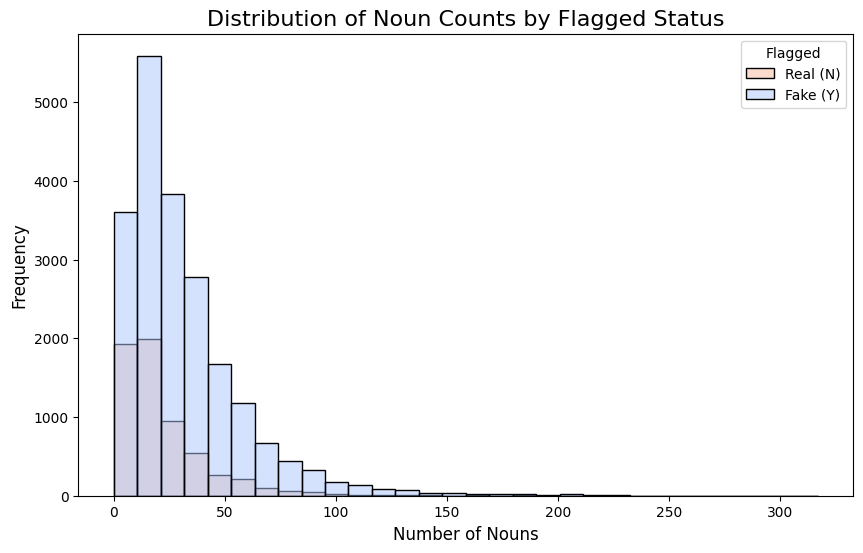

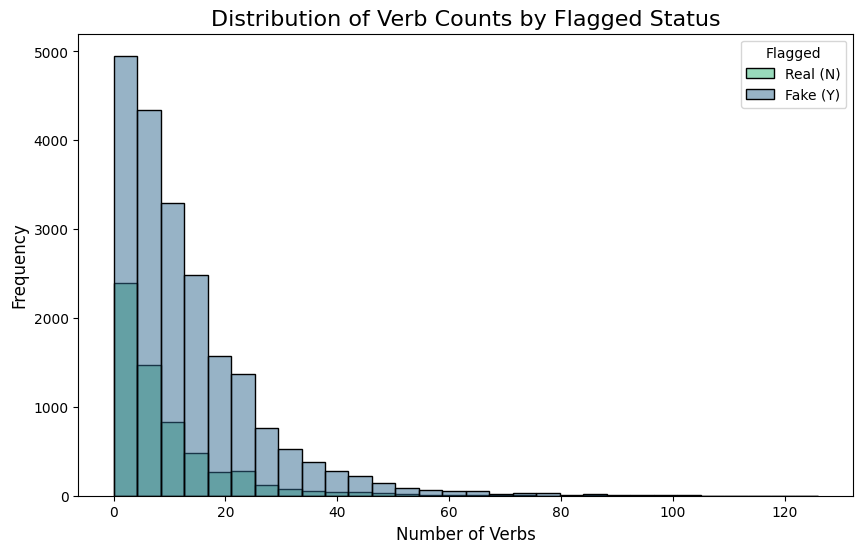

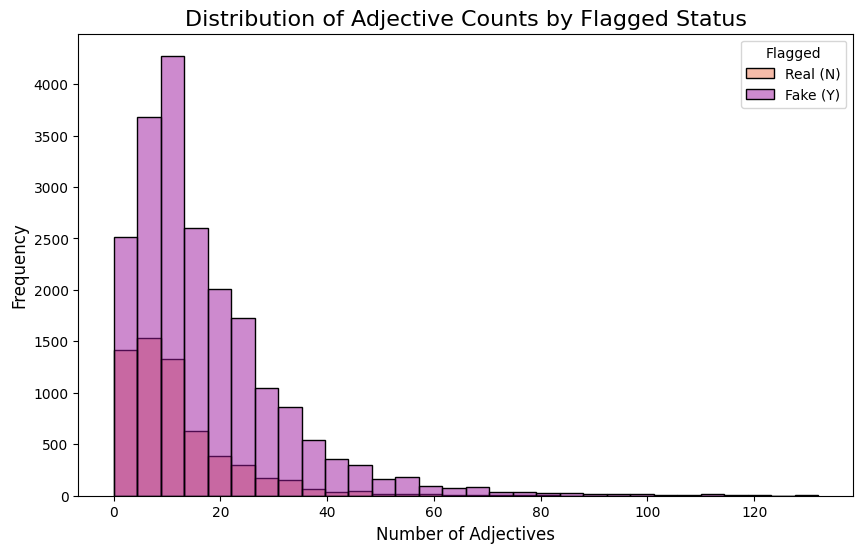

In [76]:
# Visualize noun count distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='noun_count', bins=30, hue='flagged', palette='coolwarm', common_norm=False)
plt.title('Distribution of Noun Counts by Flagged Status', fontsize=16)
plt.xlabel('Number of Nouns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

# Visualize verb count distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='verb_count', bins=30, hue='flagged', palette='viridis', common_norm=False)
plt.title('Distribution of Verb Counts by Flagged Status', fontsize=16)
plt.xlabel('Number of Verbs', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

# Visualize adjective count distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='adj_count', bins=30, hue='flagged', palette='plasma', common_norm=False)
plt.title('Distribution of Adjective Counts by Flagged Status', fontsize=16)
plt.xlabel('Number of Adjectives', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

In [77]:
df.columns

Index(['reviewContent', 'rating', 'flagged', 'yelpJoinYear', 'yelpJoinMonth',
       'dateYear', 'dateMonth', 'log_usefulCount_review',
       'log_coolCount_review', 'log_funnyCount_review', 'log_friendCount',
       'log_firstCount', 'log_tipCount', 'log_fanCount', 'state', 'word_count',
       'char_count', 'polarity', 'subjectivity', 'noun_count', 'verb_count',
       'adj_count'],
      dtype='object')

### Check for Multicollinearity in Text Features


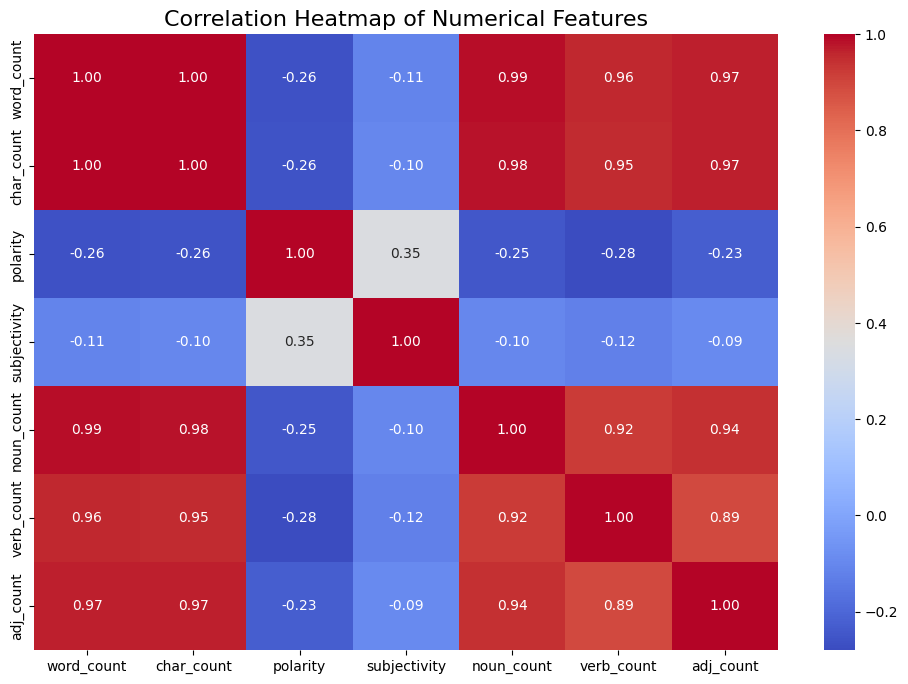

In [78]:
# Correlation Heatmap

new_numerical_features = ['word_count', 'char_count', 'polarity', 'subjectivity', 'noun_count', 'verb_count', 'adj_count']

plt.figure(figsize=(12, 8))
correlation_matrix = df[new_numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

In [79]:
# Calculate VIF
df_numerical = df[new_numerical_features]
vif_data = pd.DataFrame()
vif_data['Feature'] = df_numerical.columns
vif_data['VIF'] = [variance_inflation_factor(df_numerical.values, i) for i in range(df_numerical.shape[1])]

# Display VIF
print(vif_data)

        Feature         VIF
0    word_count  970.070607
1    char_count  446.307508
2      polarity    3.517308
3  subjectivity    5.315068
4    noun_count  145.287321
5    verb_count   54.093753
6     adj_count   66.847553


In [80]:
text_features = ['word_count', 'char_count', 'noun_count', 'adj_count']

df.drop(columns=text_features, inplace=True)

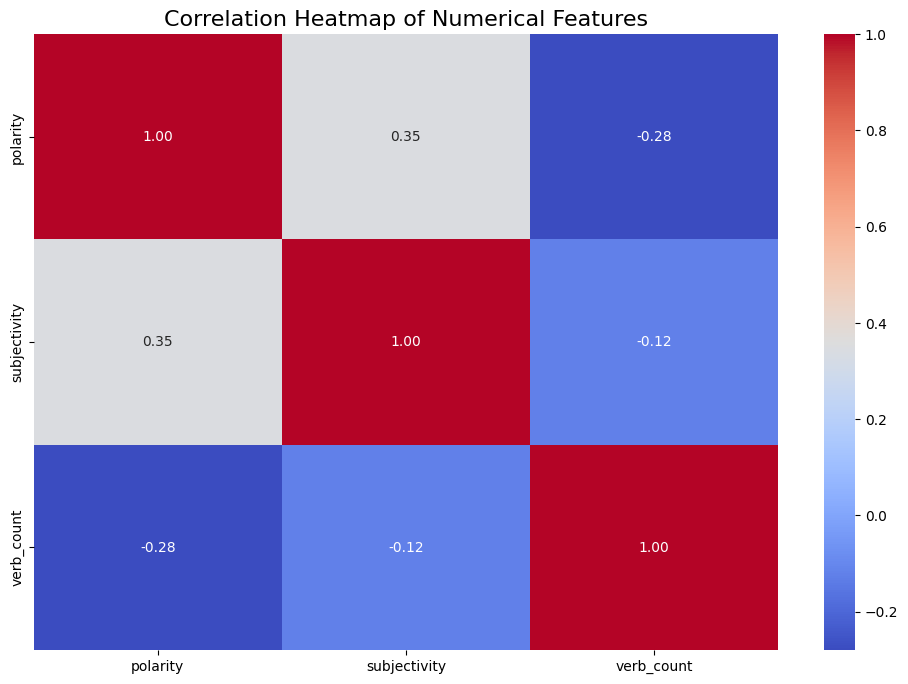

In [81]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[['polarity', 'subjectivity', 'verb_count']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

## 9. Train Test Split 
stratify=y: Ensures that the train-test split maintains the same class distribution as the original dataset.

In [82]:
df.columns

Index(['reviewContent', 'rating', 'flagged', 'yelpJoinYear', 'yelpJoinMonth',
       'dateYear', 'dateMonth', 'log_usefulCount_review',
       'log_coolCount_review', 'log_funnyCount_review', 'log_friendCount',
       'log_firstCount', 'log_tipCount', 'log_fanCount', 'state', 'polarity',
       'subjectivity', 'verb_count'],
      dtype='object')

In [83]:
X = df.drop(columns=['flagged']) 
y = df['flagged']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check class distribution in train and test sets
print("Class distribution in original data:", y.value_counts(normalize=True))
print("Class distribution in training data:", y_train.value_counts(normalize=True))
print("Class distribution in test data:", y_test.value_counts(normalize=True))

Class distribution in original data: flagged
N    0.771083
Y    0.228917
Name: proportion, dtype: float64
Class distribution in training data: flagged
N    0.771093
Y    0.228907
Name: proportion, dtype: float64
Class distribution in test data: flagged
N    0.771046
Y    0.228954
Name: proportion, dtype: float64


## 10. Feature Engineering 
Feature engineering operations (encoding, scaling etc) are fitted on X_train and apply the transformation to the X_train_balanced and X_test. This is to avoid : 
* X_train_resampled : This ensures that the transformations reflect the true distribution of the original data and prevents biases introduced by synthetic data in the oversampling process.
* X_test : data leakage. if feature engineering is done before splitting, the test data would indirectly influence the scaling parameters (mean, standard deviation, min/max), leading to data leakage. This invalidates the test set’s role as unseen data for model evaluation.

Feature Engineering operations : 
* One Hot Encoding
* Standard Scaling
* LDA for Topic Modeling


### One-Hot Encoding
One hot encode categorical features : 
* Rating 
* State

In [84]:
categorical_columns = ['rating', 'state']

In [85]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform training data
encoded_columns_train = ohe.fit_transform(X_train[categorical_columns])
encoded_df_train = pd.DataFrame(
    encoded_columns_train, 
    columns=ohe.get_feature_names_out(categorical_columns),
    index=X_train.index
)

# Transform testing data
encoded_columns_test = ohe.transform(X_test[categorical_columns])
encoded_df_test = pd.DataFrame(
    encoded_columns_test, 
    columns=ohe.get_feature_names_out(categorical_columns),
    index=X_test.index
)

# Drop original categorical columns from train and test datasets
X_train = X_train.drop(columns=categorical_columns)
X_test = X_test.drop(columns=categorical_columns)

# Concatenate the encoded columns back to train and test datasets
X_train = pd.concat([X_train.reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

### Scaling

Standard Scaling

z = (x - u) / s


In [89]:
numerical_columns_to_scale = [
  'log_usefulCount_review', 
  'log_coolCount_review',
  'log_funnyCount_review',
  'log_friendCount',
  'log_firstCount',
  'log_tipCount',
  'log_fanCount',
  'polarity',
  'subjectivity',
  'verb_count',
]

In [90]:
scaler = StandardScaler()

X_train[numerical_columns_to_scale] = scaler.fit_transform(X_train[numerical_columns_to_scale])

X_test[numerical_columns_to_scale] = scaler.transform(X_test[numerical_columns_to_scale])

### LDA for Topic Modeling

In [91]:
# Convert text to a bag-of-words representation
vectorizer = CountVectorizer(stop_words='english')  # Remove stopwords
X_train_bow = vectorizer.fit_transform(X_train['reviewContent'])
X_test_bow = vectorizer.transform(X_test['reviewContent'])

In [92]:
# Define the number of topics
n_topics = 20

# Initialize LDA
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Fit the LDA model on the Bag-of-Words matrix
lda.fit(X_train_bow)

LatentDirichletAllocation(n_components=20, random_state=42)

In [93]:
# Get the vocabulary
terms = vectorizer.get_feature_names_out()

# Display the top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    top_terms_idx = topic.argsort()[-10:][::-1]  # Indices of the top 10 terms
    top_terms = [terms[i] for i in top_terms_idx]
    print(" ".join(top_terms))

Topic #1:
good pretty got sandwich cheese like ordered food place thing
Topic #2:
dog hot falafel fry superdawg sandwich chicago best sultan love
Topic #3:
duck place good pork bbq sauce great food rice chicken
Topic #4:
table time food minute service order like came server didnt
Topic #5:
course experience food alinea wine meal restaurant service chef best
Topic #6:
beer burger good fry cheese place like really great wait
Topic #7:
good like shake place really great irazu im oatmeal try
Topic #8:
food good time really place like great im ordered ive
Topic #9:
food great restaurant greek love place service menu good really
Topic #10:
dish pork flavor menu dessert like plate cheese wine pig
Topic #11:
place food like dont good hour drink people make know
Topic #12:
meat salad bar steak good place time best food ive
Topic #13:
sushi roll crepe place good byob crab fresh tuna coast
Topic #14:
good dish food pasta chicken sauce restaurant like place italian
Topic #15:
good mexican food sal

In [94]:
# Get document-topic distributions
X_train_topics = lda.transform(X_train_bow)
X_test_topics = lda.transform(X_test_bow)

# Create a DataFrame to view the topic distribution for each document
X_train_topics_df = pd.DataFrame(X_train_topics, columns=[f"Topic_{i+1}" for i in range(n_topics)])
X_train_topics_df.head()

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20
0,0.000926,0.000926,0.000926,0.400387,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.037482,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.546390,0.000926
1,0.000794,0.000794,0.000794,0.000794,0.000794,0.212505,0.000794,0.000794,0.293384,0.000794,0.000794,0.000794,0.000794,0.000794,0.000794,0.309109,0.000794,0.000794,0.172303,0.000794
2,0.000526,0.000526,0.000526,0.279263,0.000526,0.000526,0.000526,0.000526,0.000526,0.000526,0.677029,0.000526,0.000526,0.000526,0.000526,0.034761,0.000526,0.000526,0.000526,0.000526
3,0.073198,0.001515,0.001515,0.471863,0.001515,0.293932,0.001515,0.001515,0.001515,0.136765,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
4,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.615394,0.001667,0.001667,0.001667,0.001667,0.082640,0.001667,0.001667,0.273633,0.001667,0.001667,0.001667,0.001667


In [95]:
# concat the topic distribution to the training and testing data
# Assuming X_train and X_test are DataFrames with the original features

# Convert topic distributions to DataFrames
train_topics_df = pd.DataFrame(
    X_train_topics, 
    columns=[f"Topic_{i+1}" for i in range(X_train_topics.shape[1])],  # Topic names
    index=X_train.index  # Ensure the index matches
)

test_topics_df = pd.DataFrame(
    X_test_topics, 
    columns=[f"Topic_{i+1}" for i in range(X_test_topics.shape[1])], 
    index=X_test.index  # Ensure the index matches
)

# Concatenate topic features with the original features
X_train = pd.concat([X_train.reset_index(drop=True), train_topics_df.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), test_topics_df.reset_index(drop=True)], axis=1)

In [96]:
# drop reviewContent column
X_train.drop(columns=['reviewContent'], inplace=True)
X_test.drop(columns=['reviewContent'], inplace=True)

In [99]:
X_train.shape

(21524, 59)

## 11. Preparation for Modeling 
* Convert Features to Float 
* Oversampling with SMOTE
* Validation Set

### Convert Target Feature to Integer
This is for oversampling with SMOTE to work

Flagged column : 
* N --> 0 
* Y --> 1 

In [100]:
y_train = y_train.map({'N': 0, 'Y': 1})
y_test = y_test.map({'N': 0, 'Y': 1})

In [101]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

### Oversampling 
Oversample the training data to handle class imbalance

In [102]:
smote = SMOTE(random_state=42)

In [103]:
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [104]:
y_train.value_counts(), y_train_resampled.value_counts()

(flagged
 0    16597
 1     4927
 Name: count, dtype: int64,
 flagged
 0    16597
 1    16597
 Name: count, dtype: int64)

### Validation Set
This validation set is used for evaluation and early stopping in LightGBM

In [105]:
# Split the original training data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, 
    y_train_resampled, 
    test_size=0.2, 
    stratify=y_train_resampled, 
    random_state=42
)

In [106]:
# For LightGBM ONLY - Exclude early stopping validation set from the resampled data
X_train_cv = X_train_resampled[~X_train_resampled.index.isin(X_val_split.index)]
y_train_cv = y_train_resampled[~y_train_resampled.index.isin(y_val_split.index)]

## 12. Hyperparameter Tuning
* Bayesian Optimization method is used
* Metric to tune is AUC-ROC because dataset is imbalanced and to measure the overall performance of classification
* Stratified K Fold Cross validation is done too
* [LightGBM ONLY] Avoid overfitting with validation set (eval_set) and early stopping (early_stopping_rounds)


Purpose of Early Stopping vs. Cross-Validation:
* Early stopping helps control overfitting by stopping training when validation performance stagnates.
* Cross-validation provides an estimate of model performance across different data splits.

### Tuning Hyperparameters of Random Forest

In [107]:
# Function to evaluate the Random Forest model
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap, min_impurity_decrease, max_leaf_nodes):
    n_estimators = int(n_estimators)
        
    # Define the model
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features,
        bootstrap = bool(round(bootstrap)),
        min_impurity_decrease=min_impurity_decrease,
        max_leaf_nodes=int(max_leaf_nodes),
        random_state=42,
        n_jobs=-1  # Utilize all CPU cores
    )

    model.fit(X_train_split, y_train_split)
    
    # Cross-validation for robust evaluation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_val_split, y_val_split, scoring='roc_auc', cv=skf)
    
    return np.mean(scores)  # Return the average AUC score

In [108]:
# Define the parameter bounds for Bayesian Optimization
rf_pbounds = {
    'n_estimators': (100, 400),          
    'max_depth': (5, 30),                
    'min_samples_split': (2, 20),       
    'min_samples_leaf': (1, 10),         
    'max_features': (0.1, 1.0),         
    'bootstrap': (0, 1),
    'min_impurity_decrease': (0.0, 0.1),
    'max_leaf_nodes': (10, 100)                  
}

# Initialize Bayesian optimizer
rf_optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds=rf_pbounds,
    random_state=42,
    verbose=2  # Prints progress
)

# Run the Bayesian Optimization
rf_optimizer.maximize(init_points=10, n_iter=20)

# Print the best parameters and score
print("Best Parameters for Random Forest:", rf_optimizer.max)


|   iter    |  target   | bootstrap | max_depth | max_fe... | max_le... | min_im... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9295    | 0.3745    | 28.77     | 0.7588    | 63.88     | 0.0156    | 2.404     | 3.046     | 359.9     |
| 2         | 0.9273    | 0.6011    | 22.7      | 0.1185    | 97.29     | 0.08324   | 2.911     | 5.273     | 155.0     |
| 3         | 0.9231    | 0.3042    | 18.12     | 0.4888    | 36.21     | 0.06119   | 2.255     | 7.259     | 209.9     |
| 4         | 0.9267    | 0.4561    | 24.63     | 0.2797    | 56.28     | 0.05924   | 1.418     | 12.94     | 151.2     |
| 5         | 0.9108    | 0.06505   | 28.72     | 0.9691    | 82.76     | 0.03046   | 1.879     | 14.32     | 232.0     |
| 6         | 0.9372    | 0.122     | 17.38     | 0.1309    | 91.84     | 0.02588   | 6.963     | 7.611     | 256.0     |
| 7         | 0.9066    

In [109]:
rf_optimized_params = rf_optimizer.max['params']

# Convert parameters that need to be integers
rf_optimized_params['n_estimators'] = int(rf_optimized_params['n_estimators'])
rf_optimized_params['max_depth'] = int(rf_optimized_params['max_depth'])
rf_optimized_params['min_samples_split'] = int(rf_optimized_params['min_samples_split'])
rf_optimized_params['min_samples_leaf'] = int(rf_optimized_params['min_samples_leaf'])
rf_optimized_params['bootstrap'] = bool(round(rf_optimized_params['bootstrap']))
rf_optimized_params['max_leaf_nodes'] = int(rf_optimized_params['max_leaf_nodes'])

rf_optimized_params

{'bootstrap': True,
 'max_depth': 11,
 'max_features': 0.30951858895289774,
 'max_leaf_nodes': 95,
 'min_impurity_decrease': 0.0022880091335956143,
 'min_samples_leaf': 6,
 'min_samples_split': 13,
 'n_estimators': 365}

### Tuning hyperparameters of XGBoost

In [110]:
# Function to evaluate the XGBoost model
def xgb_evaluate(learning_rate, max_depth, n_estimators, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda, gamma):

    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),  # Convert to integer
        n_estimators=int(n_estimators),  # Convert to integer
        min_child_weight=int(min_child_weight),  # Convert to integer
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
    )
    
    model.fit(
        X_train_split, y_train_split,
        verbose=False
    )
    
    # Cross-validation score (use StratifiedKFold for balanced splits)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_val_split, y_val_split, scoring='roc_auc', cv=skf)
    
    return np.mean(scores)

In [111]:
# Define the parameter bounds
xgb_pbounds = {
    'learning_rate': (0.01, 0.05),
    'max_depth': (6, 12),
    'n_estimators': (100, 400),
    'min_child_weight': (1, 5),
    'subsample': (0.5, 0.8),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 1.4),
    'reg_lambda': (0.01, 1.0),
    'gamma': (0, 5)
}

xgb_optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=xgb_pbounds,
    random_state=42,
)

# Run optimization
xgb_optimizer.maximize(init_points=10, n_iter=20)

# Print the best parameters and score
print("Best Parameters for XGBoost:", xgb_optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9711    | 0.6873    | 4.754     | 0.03928   | 9.592     | 1.624     | 146.8     | 0.08132   | 0.8675    | 0.6803    |
| 2         | 0.9734    | 0.854     | 0.1029    | 0.0488    | 10.99     | 1.849     | 154.5     | 0.2568    | 0.3112    | 0.6574    |
| 3         | 0.9719    | 0.716     | 1.456     | 0.03447   | 6.837     | 2.169     | 209.9     | 0.6385    | 0.7873    | 0.5599    |
| 4         | 0.9624    | 0.7571    | 2.962     | 0.01186   | 9.645     | 1.682     | 119.5     | 1.328     | 0.966     | 0.7425    |
| 5         | 0.974     | 0.6523    | 0.4884    | 0.03737   | 8.641     | 1.488     | 248.6     | 0.04814   | 0.9102    | 0.5776    |
| 6         | 0.9739    | 0.8313    | 1.559     | 0.0308    | 

In [112]:
# Extract the optimized parameters
xgb_optimized_params = xgb_optimizer.max['params']

# Convert parameters that need to be integers
xgb_optimized_params['max_depth'] = int(xgb_optimized_params['max_depth'])
xgb_optimized_params['n_estimators'] = int(xgb_optimized_params['n_estimators'])
xgb_optimized_params['min_child_weight'] = int(xgb_optimized_params['min_child_weight'])

xgb_optimized_params

{'colsample_bytree': 0.6359422887938448,
 'gamma': 0.15784676710897005,
 'learning_rate': 0.019943050469368215,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 390,
 'reg_alpha': 0.7110934442160463,
 'reg_lambda': 0.3413049633209934,
 'subsample': 0.7834245703955892}

### Tuning hyperparameters of LightGBM

In [113]:
# Function to evaluate the model
def lgb_evaluate(num_leaves, max_depth, learning_rate, feature_fraction, bagging_fraction, lambda_l1, lambda_l2):

    model = LGBMClassifier(
        num_leaves=int(num_leaves),  # Convert to integer
        max_depth=int(max_depth),  # Convert to integer
        learning_rate=learning_rate,
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        objective='binary',
        metric='auc',
        random_state=42,
        verbose=-1
    )
    # Fit the model with early stopping
    model.fit(X_train_split, y_train_split,
              eval_metric='auc',
              eval_set=[(X_val_split, y_val_split)])
    
    # Cross-validation for robust evaluation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_cv, y_train_cv, scoring='roc_auc', cv=skf)
    
    return np.mean(scores)

In [114]:
# Define the parameter bounds for Bayesian Optimization
lgb_pbounds = {
    'num_leaves': (30, 70),
    'max_depth': (5, 20),
    'learning_rate': (0.01, 0.1),
    'feature_fraction': (0.6, 1.0),
    'bagging_fraction': (0.6, 1.0),
    'lambda_l1': (0, 1),
    'lambda_l2': (0, 1)
}

# Initialize Bayesian optimizer
lgb_optimizer = BayesianOptimization(
    f=lgb_evaluate,
    pbounds=lgb_pbounds,
    random_state=42,
    verbose=2  # Prints progress
)

# Run the Bayesian Optimization
lgb_optimizer.maximize(init_points=10, n_iter=50)

# Print the best parameters and score
print("Best Parameters for LightGBM:", lgb_optimizer.max)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9676    | 0.7498    | 0.9803    | 0.732     | 0.5987    | 0.02404   | 7.34      | 32.32     |
| 2         | 0.9821    | 0.9465    | 0.8404    | 0.7081    | 0.02058   | 0.09729   | 17.49     | 38.49     |
| 3         | 0.9786    | 0.6727    | 0.6734    | 0.3042    | 0.5248    | 0.04888   | 9.368     | 54.47     |
| 4         | 0.9803    | 0.6558    | 0.7169    | 0.3664    | 0.4561    | 0.08067   | 7.995     | 50.57     |
| 5         | 0.9742    | 0.837     | 0.6186    | 0.6075    | 0.1705    | 0.01585   | 19.23     | 68.63     |
| 6         | 0.9744    | 0.9234    | 0.7218    | 0.09767   | 0.6842    | 0.04961   | 6.831     | 49.81     |
| 7         | 0.977     | 0.6138    | 0.9637    | 0.2588    | 0.6625    | 0.03805   | 12.8      | 51.87     |
| 8       

In [115]:
# Extract the optimized parameters
lgb_optimized_params = lgb_optimizer.max['params']

# Convert parameters that need to be integers
lgb_optimized_params['num_leaves'] = int(lgb_optimized_params['num_leaves'])
lgb_optimized_params['max_depth'] = int(lgb_optimized_params['max_depth'])

print("Optimized LightGBM Parameters:", lgb_optimized_params)

Optimized LightGBM Parameters: {'bagging_fraction': 0.6250964731525723, 'feature_fraction': 0.9937677734465369, 'lambda_l1': 0.230792818874879, 'lambda_l2': 0.07324412868601282, 'learning_rate': 0.0991904833425169, 'max_depth': 18, 'num_leaves': 65}


## 13. Modeling
* Baseline : Logistic Regression
* Tree Model : Random Forest
* Boosting Model : XGBoost
* Microsoft : LightGBM
* Stacking Ensemble Classifier : LightGBM, XGBoost (Logistic Regression as meta-model)

Classification report is shown under each model

### Helper Function

In [116]:
# Helper function to get model performance on training data 
def performance_on_train(model, X, y):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:,1]
    result_dict = dict()
    
    # confusion matrix 
    cfn_matrix = metrics.confusion_matrix(y, y_pred, labels=[1, 0])
    print("Train Confusion Matrix:\n", cfn_matrix)
    
    # accuracy 
    accuracy = metrics.accuracy_score(y, y_pred)
    print("Train Accuracy: ", accuracy)
    result_dict["Accuracy"] = accuracy
    
    # precision
    precision = metrics.precision_score(y, y_pred)
    print("Train Precision: ", precision)
    result_dict["Precision"] = precision
    
    # recall
    recall = metrics.recall_score(y, y_pred)
    print("Train Recall: ", recall)
    result_dict["Recall"] = recall

    # f1 score
    f1 = metrics.f1_score(y, y_pred)
    print("Train F1 Score: ", f1)
    result_dict["F1 Score"] = f1
    
    # auc score
    auc = metrics.roc_auc_score(y, y_pred_proba)
    print("Train AUC: ", auc)
    result_dict["AUC"] = auc
    
    return result_dict

In [117]:
# Helper function to get model performance on test data 
def performance_on_test(model, X, y):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:,1]
    result_dict = dict()
    
    # confusion matrix 
    cfn_matrix = metrics.confusion_matrix(y, y_pred, labels=[1, 0])
    print("Test Confusion Matrix:\n", cfn_matrix)
    
    # accuracy 
    accuracy = metrics.accuracy_score(y, y_pred)
    print("Test Accuracy: ", accuracy)
    result_dict["Accuracy"] = accuracy
    
    # precision
    precision = metrics.precision_score(y, y_pred)
    print("Test Precision: ", precision)
    result_dict["Precision"] = precision
    
    # recall
    recall = metrics.recall_score(y, y_pred)
    print("Test Recall: ", recall)
    result_dict["Recall"] = recall

    # f1 score
    f1 = metrics.f1_score(y, y_pred)
    print("Test F1 Score: ", f1)
    result_dict["F1 Score"] = f1
    
    # auc score
    auc = metrics.roc_auc_score(y, y_pred_proba)
    print("Test AUC: ", auc)
    result_dict["AUC"] = auc
    
    return result_dict

### Modeling - Logistic Regression (Baseline)

In [118]:
logreg_model = LogisticRegression(random_state=42,  max_iter=500)
logreg_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=500, random_state=42)

In [119]:
print('Logistic Regression model performance on training data :')
logreg_perf_train = performance_on_train(logreg_model, X_train_resampled, y_train_resampled)

Logistic Regression model performance on training data :
Train Confusion Matrix:
 [[15515  1082]
 [ 2742 13855]]
Train Accuracy:  0.8847984575525697
Train Precision:  0.8498110313852221
Train Recall:  0.9348074953304815
Train F1 Score:  0.890285189648247
Train AUC:  0.9473097565901023


In [120]:
print('Logistic Regression model performance on test data :')
logreg_perf_test = performance_on_test(logreg_model, X_test, y_test)

Logistic Regression model performance on test data :
Test Confusion Matrix:
 [[1122  110]
 [ 659 3490]]
Test Accuracy:  0.8570897602676083
Test Precision:  0.6299831555306008
Test Recall:  0.9107142857142857
Test F1 Score:  0.7447726518420179
Test AUC:  0.9410795278474237


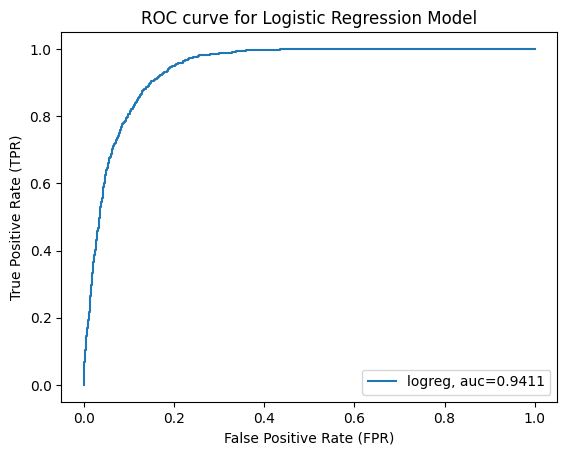

In [121]:
# plot roc curve for Logistic Regression model on test data 

y_pred_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_logreg)
auc_logreg = metrics.roc_auc_score(y_test, y_pred_proba_logreg)

plt.plot(fpr, tpr, label="logreg, auc="+str("{:.4f}".format(auc_logreg)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

### Modeling - Random Forest

In [122]:
rf_model = RandomForestClassifier(**rf_optimized_params, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=11, max_features=0.30951858895289774,
                       max_leaf_nodes=95,
                       min_impurity_decrease=0.0022880091335956143,
                       min_samples_leaf=6, min_samples_split=13,
                       n_estimators=365, random_state=42)

In [123]:
print('Random Forest model performance on training data :')
rf_perf_train = performance_on_train(rf_model, X_train_resampled, y_train_resampled)

Random Forest model performance on training data :
Train Confusion Matrix:
 [[14962  1635]
 [ 2134 14463]]
Train Accuracy:  0.8864553835030428
Train Precision:  0.8751754796443613
Train Recall:  0.9014882207627885
Train F1 Score:  0.8881370017511055
Train AUC:  0.9536281509696009


In [124]:
print('Random Forest model performance on test data :')
rf_perf_test = performance_on_test(rf_model, X_test, y_test)

Random Forest model performance on test data :
Test Confusion Matrix:
 [[1023  209]
 [ 512 3637]]
Test Accuracy:  0.866010035309422
Test Precision:  0.6664495114006515
Test Recall:  0.8303571428571429
Test F1 Score:  0.7394289844597036
Test AUC:  0.9322151245958188


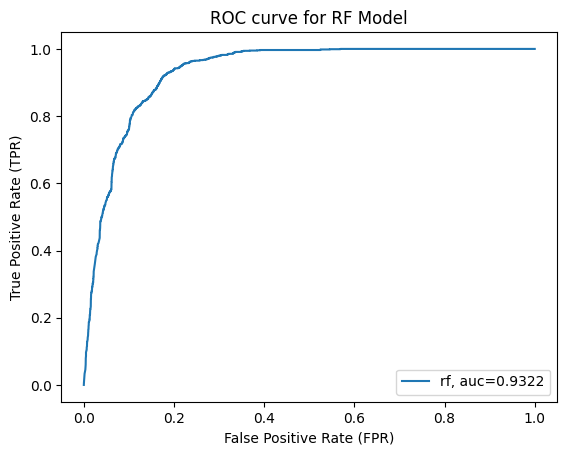

In [125]:
# plot roc curve
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_rf)
auc_rf = metrics.roc_auc_score(y_test, y_pred_proba_rf)

plt.plot(fpr, tpr, label="rf, auc="+str("{:.4f}".format(auc_rf)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve for RF Model')
plt.show()

### Modeling - XGBoost

In [126]:
xgb_model = XGBClassifier(**xgb_optimized_params, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6359422887938448, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.15784676710897005,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.019943050469368215,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=390, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [127]:
print('XGB performance on training data :')
xgb_perf_train = performance_on_train(xgb_model, X_train_resampled, y_train_resampled)

XGB performance on training data :
Train Confusion Matrix:
 [[16152   445]
 [  957 15640]]
Train Accuracy:  0.9577634512261252
Train Precision:  0.9440645274416973
Train Recall:  0.97318792552871
Train F1 Score:  0.9584050317450898
Train AUC:  0.9942352387199134


In [128]:
print('XGB performance on test data :')
xgb_perf_test = performance_on_test(xgb_model, X_test, y_test)

XGB performance on test data :
Test Confusion Matrix:
 [[1014  218]
 [ 383 3766]]
Test Accuracy:  0.8883107229139565
Test Precision:  0.7258410880458125
Test Recall:  0.823051948051948
Test F1 Score:  0.7713959680486877
Test AUC:  0.9494654086573826


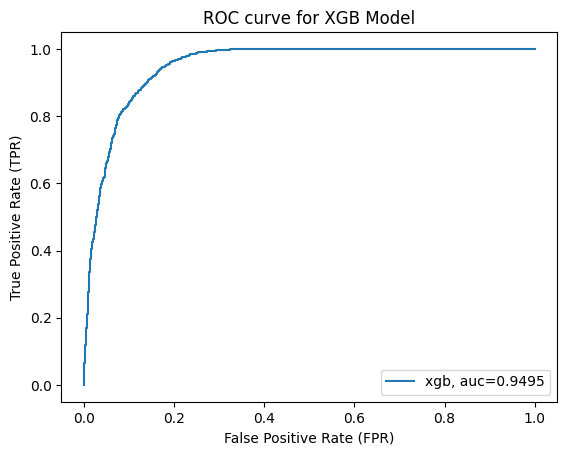

In [129]:
# plot roc curve 
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = metrics.roc_auc_score(y_test, y_pred_proba_xgb)

plt.plot(fpr, tpr, label="xgb, auc="+str("{:.4f}".format(auc_xgb)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve for XGB Model')
plt.show()

### Modeling - LightGBM

In [130]:
lgb_model = LGBMClassifier(**lgb_optimized_params, random_state=42, verbose=-1)
lgb_model.fit(X_train_resampled, y_train_resampled)

LGBMClassifier(bagging_fraction=0.6250964731525723,
               feature_fraction=0.9937677734465369, lambda_l1=0.230792818874879,
               lambda_l2=0.07324412868601282, learning_rate=0.0991904833425169,
               max_depth=18, num_leaves=65, random_state=42, verbose=-1)

In [131]:
print('LightGBM performance on training data :')
lgb_perf_train = performance_on_train(lgb_model, X_train_resampled, y_train_resampled)

LightGBM performance on training data :
Train Confusion Matrix:
 [[16165   432]
 [  692 15905]]
Train Accuracy:  0.9661384587576068
Train Precision:  0.9589488046508868
Train Recall:  0.9739711996143882
Train F1 Score:  0.9664016261134692
Train AUC:  0.9964946650464024


In [132]:
print('LightGBM performance on test data :')
lgb_perf_test = performance_on_test(lgb_model, X_test, y_test)

LightGBM performance on test data :
Test Confusion Matrix:
 [[1000  232]
 [ 368 3781]]
Test Accuracy:  0.8884965619773276
Test Precision:  0.7309941520467836
Test Recall:  0.8116883116883117
Test F1 Score:  0.7692307692307693
Test AUC:  0.9495634216350051


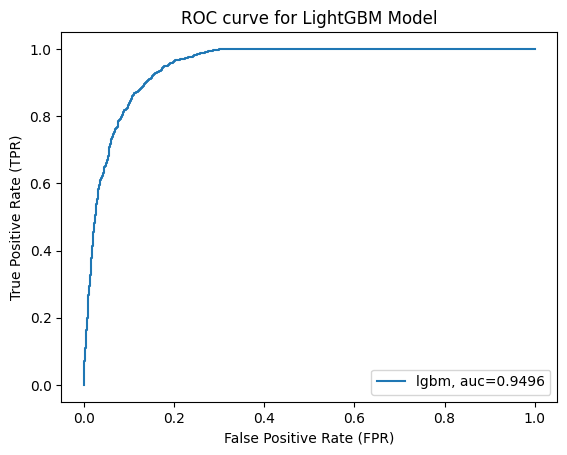

In [133]:
# plot roc curve
y_pred_proba_lgbm = lgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_lgbm)
auc_lgbm = metrics.roc_auc_score(y_test, y_pred_proba_lgbm)

plt.plot(fpr, tpr, label="lgbm, auc="+str("{:.4f}".format(auc_lgbm)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve for LightGBM Model')
plt.show()

### Modeling - Stacking Ensemble Classifier 
* Estimators : XGBoost, LightGBM 
* Meta-model (final estimator): Logistic Regression

In [134]:
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=logreg_model,
    passthrough=True,
)
stacking_model.fit(X_train_resampled, y_train_resampled)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6359422887938448,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.15784676710897005,
                                              grow_policy=None,
                                              importance_type=None,
                                              interacti...
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lgb',
                                LGBMClassifier(bagging_fraction=0.6250964731525723,
                                               feature_fraction=0.9937677734465369,
                                               lambda_l1=0.230792818874879,
                                               lambda_l2=0.07324412868601282,
                                               learning_rate=0.0991904833425169,
                                               max_depth=18, num_leaves=65,
                                               random_state=42, verbose=-1))],
                   final_estimator=LogisticRegression(max_iter=500,
                                                      random_state=42),
                   passthrough=True)

In [135]:
print('Stacking Ensemble performance on training data :')
stack_perf_train = performance_on_train(stacking_model, X_train_resampled, y_train_resampled)

Stacking Ensemble performance on training data :
Train Confusion Matrix:
 [[16229   368]
 [ 1085 15512]]
Train Accuracy:  0.9562270289811412
Train Precision:  0.9373339494051057
Train Recall:  0.9778273181900343
Train F1 Score:  0.9571525463713839
Train AUC:  0.9939119563276334


In [136]:
print('Stacking Ensemble performance on test data :')
stack_perf_test = performance_on_test(stacking_model, X_test, y_test)

Stacking Ensemble performance on test data :
Test Confusion Matrix:
 [[1038  194]
 [ 415 3734]]
Test Accuracy:  0.8868240104069876
Test Precision:  0.7143840330350998
Test Recall:  0.8425324675324676
Test F1 Score:  0.7731843575418994
Test AUC:  0.9504024988027155


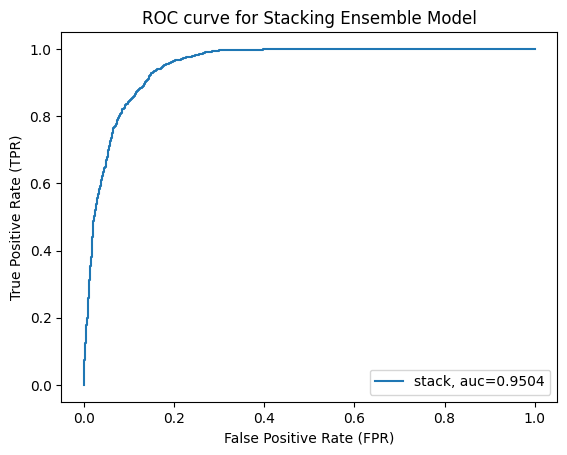

In [137]:
# plot roc curve
y_pred_proba_stack = stacking_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_stack)
auc_stack = metrics.roc_auc_score(y_test, y_pred_proba_stack)

plt.plot(fpr, tpr, label="stack, auc="+str("{:.4f}".format(auc_stack)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve for Stacking Ensemble Model')
plt.show()

## 14. Model Evaluation
For train and test : 
* Accuracy 
* Precision 
* Recall 
* F1 score
* AUC

In [138]:
# Performance evaluation table on training data

performance_table_train = pd.DataFrame()

performance_table_train = pd.concat([
    performance_table_train,
    pd.DataFrame([logreg_perf_train]),
    pd.DataFrame([rf_perf_train]),
    pd.DataFrame([xgb_perf_train]),
    pd.DataFrame([lgb_perf_train]),
    pd.DataFrame([stack_perf_train])
], ignore_index=True)

performance_table_train = performance_table_train.map(lambda x: f'{x:.4f}' if isinstance(x, float) else x)

performance_table_train.index = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Stacking Ensemble']

print('Model Performance on Training Data:')
print(performance_table_train)

Model Performance on Training Data:
                    Accuracy Precision  Recall F1 Score     AUC
Logistic Regression   0.8848    0.8498  0.9348   0.8903  0.9473
Random Forest         0.8865    0.8752  0.9015   0.8881  0.9536
XGBoost               0.9578    0.9441  0.9732   0.9584  0.9942
LightGBM              0.9661    0.9589  0.9740   0.9664  0.9965
Stacking Ensemble     0.9562    0.9373  0.9778   0.9572  0.9939


In [139]:
# Performance evaluation table on test data

performance_table_test = pd.DataFrame()

performance_table_test = pd.concat([
    performance_table_test,
    pd.DataFrame([logreg_perf_test]),
    pd.DataFrame([rf_perf_test]),
    pd.DataFrame([xgb_perf_test]),
    pd.DataFrame([lgb_perf_test]),
    pd.DataFrame([stack_perf_test])
], ignore_index=True)

performance_table_test = performance_table_test.map(lambda x: f'{x:.4f}' if isinstance(x, float) else x)

performance_table_test.index = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Stacking Ensemble']

print('Model Performance on Test Data:')
print(performance_table_test)

Model Performance on Test Data:
                    Accuracy Precision  Recall F1 Score     AUC
Logistic Regression   0.8571    0.6300  0.9107   0.7448  0.9411
Random Forest         0.8660    0.6664  0.8304   0.7394  0.9322
XGBoost               0.8883    0.7258  0.8231   0.7714  0.9495
LightGBM              0.8885    0.7310  0.8117   0.7692  0.9496
Stacking Ensemble     0.8868    0.7144  0.8425   0.7732  0.9504


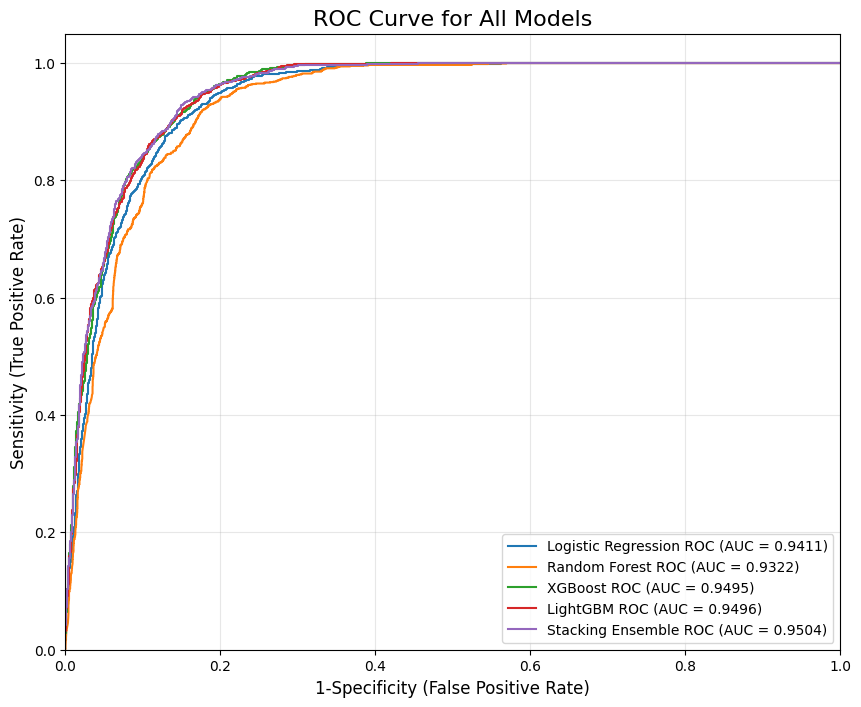

In [140]:
# Probabilities for each model
y_pred_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Combine predictions and labels
probas = [y_pred_proba_logreg, y_pred_proba_rf, y_pred_proba_xgb, y_pred_proba_lgb, y_pred_proba_stack]
labels = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Stacking Ensemble']

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(len(probas)):  # Loop over each model
    fpr, tpr, _ = metrics.roc_curve(y_test, probas[i])
    auc = metrics.roc_auc_score(y_test, probas[i])
    plt.plot(fpr, tpr, label='%s ROC (AUC = %.4f)' % (labels[i], auc))

# Set plot details
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC Curve for All Models', fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()